In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import gzip
import operator
from scipy import stats
import scipy as sp
import community
import datetime as dt
import pandas as pd
from network_ei import *
from get_motifs import *
from causal_emergence import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

# Causal Structure as a Network: Quantifying Certainty in Complex Systems

# Chapter 06: Macronodes

In [4]:
p0=0

In [5]:
def plot_degree(degree, number_of_bins=50, log_binning=False, base=2):
    """Plot the degree distribution with (log) binning."""
    lower_bound = min(degree)
    upper_bound = max(degree)
    
    if log_binning:
        log = np.log2 if base == 2 else np.log10
        lower_bound = log(lower_bound) if lower_bound >= 1 else 0.0
        upper_bound = log(upper_bound)
        bins = np.logspace(lower_bound,upper_bound,number_of_bins, base=base)
    else:
        bins = np.linspace(lower_bound,upper_bound,number_of_bins)
    
    y, __ = np.histogram(degree, bins=bins, density=True)
    x = bins[1:] - np.diff(bins)/2.0
        
    return x,y

In [6]:
def do_net(G, source, target, n_sim=10000, p0=np.exp(-16)):
    """Intervene"""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
    
    fpt_list = {}
    Wout = get_Wout_full(G, p0)
    Win = get_Win(G, p0)
    next_node = source
    
    for i in range(n_sim):
        next_node = source
        lisss = [source]
        while next_node != target:
            next_node = np.nonzero(np.random.multinomial(1, np.round(Wout[next_node],2)))[0][0]
            lisss.append(next_node)
        fpt_list[i] = len(lisss)
        
    return list(fpt_list.values())

In [7]:
G = nx.barabasi_albert_graph(10,3)
macro_mapping = dict(zip(G.nodes(), G.nodes()))

Wout = get_Wout_full(G, p0=0)

n_macros = 2
macro_mapping[7] = G.number_of_nodes()
macro_mapping[8] = G.number_of_nodes()
macro_mapping[5] = G.number_of_nodes()+1
macro_mapping[6] = G.number_of_nodes()+1

In [8]:
# October 26th
def get_macro(G, macro_mapping, p0=0):
    """
    Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
    - param G: current micro graph
    - param macro_mapping: a dictionary with {micro_node:macro_node}
    - param p0: smallest probability
    
    - output: Macro, a macro-level transition-probability matrix
    """
    # might have to assert node_labels to be integers
    G = prepare_network(G,p0=p0)
    micro_network_size = G.number_of_nodes()
    micro_Wout = get_Wout_full(G, p0)
    micro_nodes = np.unique(list(macro_mapping.keys()))
    nodes_in_macro_network = np.unique(list(macro_mapping.values()))

    macro_network_size = len(nodes_in_macro_network)
    macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
    n_macro = len(macro_nodes)
    
    if n_macro==0:
        return micro_Wout
    
    micro_to_macro_list = []
    for macro_i in range(n_macro):
        micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
        micro_to_macro_list.append(micro_in_macro_i)
    
    # get new rows
    macro_row_list = []
    for macro_i in micro_to_macro_list:
        macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
    macro_rows = np.vstack(macro_row_list)

    # get new cols
    macro_col_list = []
    for macro_i in micro_to_macro_list:
        macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

    macro_cols = np.vstack(macro_col_list)    
    macro_cols = macro_cols.T
    
    # get stubby diagonal square in the bottom right
    macro_bottom_right = np.zeros((n_macro,n_macro))
    for macro_i in range(n_macro):
        for macro_j in range(n_macro):
            macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

    # put them all together in a matrix that is too big
    too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
    macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
    Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    
    return Macro

In [9]:
# def causal_emergence(G, p0=0, thresh=0.0001):
#     """
#     Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
#     - param G: a networkx object or adjacency matrix or TPM
#     - param p0: smallest probability
    
#     - output Gm: a macro-scale network object with higher EI than G
#     """
#     G = prepare_network(G, p0) # makes the network weighted, directed if it's not already
#     current_ei = get_ei(G, p0)
#     micro_nodes_left = list(G.nodes())
#     micros_that_have_been_macroed = []
#     macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    
#     np.random.shuffle(micro_nodes_left)
#     for node_i in micro_nodes_left:
#         print(node_i)
#         # if node_i not in micros_that_have_been_macroed:
#         # first assemble a list of node_js to span called macros_to_check
#         neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
#         for node_j in neighbors_i:
#             neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
#             neighbors_i = neighbors_j.union(neighbors_i)
#         macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
#         queue = macros_to_check.copy()

#         node_i_macro = macro_mapping[node_i]
#         if node_i_macro == node_i:
#             node_i_macro = max(list(macro_mapping.values()))+1
        
#         # list of nodes that DO NOT add to EI
        
#         while len(queue) > 0:
#             print(queue)
#             np.random.shuffle(queue)
#             possible_macro = queue.pop()

#             possible_mapping = macro_mapping.copy()
#             possible_mapping[node_i]         = node_i_macro
#             possible_mapping[possible_macro] = node_i_macro

#             MACRO = get_macro(G, possible_mapping, p0)
#             macro_ei = get_ei(MACRO, p0)
#             Gm = prepare_network(MACRO, p0=p0)
            
#             # if macro_ei - current_ei < thresh:
#                 # pass # go to beginning of while loop
            
#             if macro_ei - current_ei > thresh:
#             # keep adding shit in the queue to the current_macro_grouping, once you get anything 
#             # with a little extra EI
#                 current_ei = macro_ei
#                 macro_mapping = possible_mapping
#                 micros_that_have_been_macroed.append(node_i)
#                 micros_that_have_been_macroed.append(possible_macro)
#                 micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

#                 nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
#                 #################
#                 #################
#                 #################
                
#                 # also don't add the node_j to the set(queue)
#                 for new_micro_in_macro_i in nodes_in_macro_i:
#                     neighbors_Mi = set(list(G.successors(new_micro_in_macro_i\
#                                                         ))).union(set(list(G.predecessors(new_micro_in_macro_i))))
#                     for node_Mj in neighbors_Mi:
#                         neighbors_Mj = set(list(G.successors(node_Mj))).union(set(list(G.predecessors(node_Mj))))
#                         neighbors_Mi = neighbors_j.union(neighbors_Mi)
#                 new_friends_of_i = [i for i in list(neighbors_Mi) if i!=node_i]
#                 diff = list(set(new_friends_of_i) - set(macros_to_check))
#                 if diff:
#                     for new_friend in diff:
#                         queue.append(new_friend)
#                         macros_to_check.append(new_friend)
    
#     MACRO = get_macro(G, macro_mapping, p0)
#     Gm = prepare_network(G, p0=p0)
#     return Gm

In [10]:
# PRINT VERSION, WORKS
def causal_emergence(G, p0=0, thresh=0.0001):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0) # makes the network weighted, directed if it's not already
    current_ei = get_ei(G, p0)
    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
    print("\nSearch started... current_ei = %.4f"%current_ei)

    np.random.shuffle(micro_nodes_left)
    for node_i in micro_nodes_left:
        print("...")

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        queue = macros_to_check.copy()

        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
            
        while len(queue) > 0:
            np.random.shuffle(queue)
            possible_macro = queue.pop()

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro

            MACRO = get_macro(G, possible_mapping, p0)
            macro_ei = get_ei(MACRO, p0)
            Gm = prepare_network(MACRO, p0=p0)

            if macro_ei - current_ei > thresh:
            # keep adding shit in the queue to the current_macro_grouping, once you get anything 
            # with a little extra EI
                current_ei = macro_ei
                macro_mapping = possible_mapping
                print("just found successful macro grouping... current_ei = %.4f"%current_ei)
                micros_that_have_been_macroed.append(node_i)
                micros_that_have_been_macroed.append(possible_macro)
                micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

                nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
                for new_micro_in_macro_i in nodes_in_macro_i:
                    neighbors_Mi = set(list(
                        G.successors(new_micro_in_macro_i))).\
                        union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
                    for node_Mj in neighbors_Mi:
                        if node_Mj not in queue and node_Mj != node_i:
                            queue.append(node_Mj)
                            
    MACRO = get_macro(G, macro_mapping, p0)
    Gm = prepare_network(MACRO, p0=p0)
    return Gm, macro_mapping, G

In [11]:
def causal_emergence(G, p0=0, thresh=0.0001):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0) # makes the network weighted, directed if it's not already
    current_ei = get_ei(G, p0)
    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    

    np.random.shuffle(micro_nodes_left)
    for node_i in micro_nodes_left:
#         print("...")

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        queue = macros_to_check.copy()

        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
            
        while len(queue) > 0:
            np.random.shuffle(queue)
            possible_macro = queue.pop()

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro

            MACRO = get_macro(G, possible_mapping, p0)
            macro_ei = get_ei(MACRO, p0)
            Gm = prepare_network(MACRO, p0=p0)

            if macro_ei - current_ei > thresh:
            # keep adding shit in the queue to the current_macro_grouping, once you get anything 
            # with a little extra EI
                current_ei = macro_ei
                macro_mapping = possible_mapping
                micros_that_have_been_macroed.append(node_i)
                micros_that_have_been_macroed.append(possible_macro)
                micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

                nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
                for new_micro_in_macro_i in nodes_in_macro_i:
                    neighbors_Mi = set(list(
                        G.successors(new_micro_in_macro_i))).\
                        union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
                    for node_Mj in neighbors_Mi:
                        if node_Mj not in queue and node_Mj != node_i:
                            queue.append(node_Mj)
                            
    MACRO = get_macro(G, macro_mapping, p0)
    Gm = prepare_network(MACRO, p0=p0)
    return Gm, macro_mapping, G

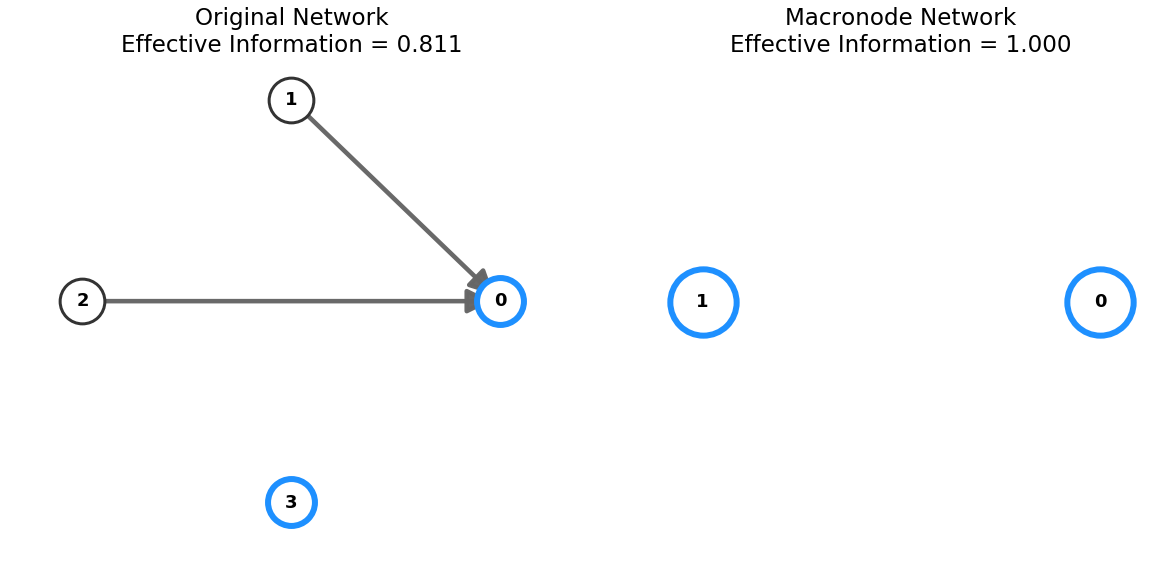

In [12]:
tpm = np.array([[1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [0, 0, 0, 1]])

mG, mapping, G_orig = causal_emergence(tpm,p0)

ns = 2000
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,9))
pos = nx.circular_layout(G_orig)
nx.draw_networkx_nodes(G_orig, pos, node_color='w', node_size=ns, 
                       linewidths=3, ax=ax0).set_edgecolor('#333333')
for eij in G_orig.edges():
    i = eij[0]
    j = eij[1]
    if i==j:
        nx.draw_networkx_nodes(G_orig, pos, nodelist=[i], node_size=ns+ns*.1, node_color='w', 
                       linewidths=6, ax=ax0).set_edgecolor('dodgerblue')

nx.draw_networkx_edges(G_orig, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax0, arrowsize=50)
title = "Original Network\nEffective Information = %.3f"%(np.round(get_ei(G_orig,p0),5))
nx.draw_networkx_labels(G_orig, pos, font_size=18, font_color='k', font_weight='bold', ax=ax0)
ax0.set_title(title, size=23)
ax0.axis('off')

ns = 2000
pos = nx.circular_layout(mG)
nx.draw_networkx_nodes(mG, pos, node_color='w', node_size=ns*2, 
                       linewidths=3, ax=ax1).set_edgecolor('#333333')
nx.draw_networkx_edges(mG, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax1, arrowsize=50)
for eij in mG.edges():
    i = eij[0]
    j = eij[1]
    if i==j:
        nx.draw_networkx_nodes(mG, pos, nodelist=[i], node_size=(ns+ns*.1)*2, node_color='w',
                       linewidths=6, ax=ax1).set_edgecolor('dodgerblue')

title = "Macronode Network\nEffective Information = %.3f"%(np.round(get_ei(mG,p0),5))
nx.draw_networkx_labels(mG, pos, font_size=18, font_color='k', font_weight='bold', ax=ax1)
ax1.set_title(title, size=23)
ax1.axis('off')

plt.show()

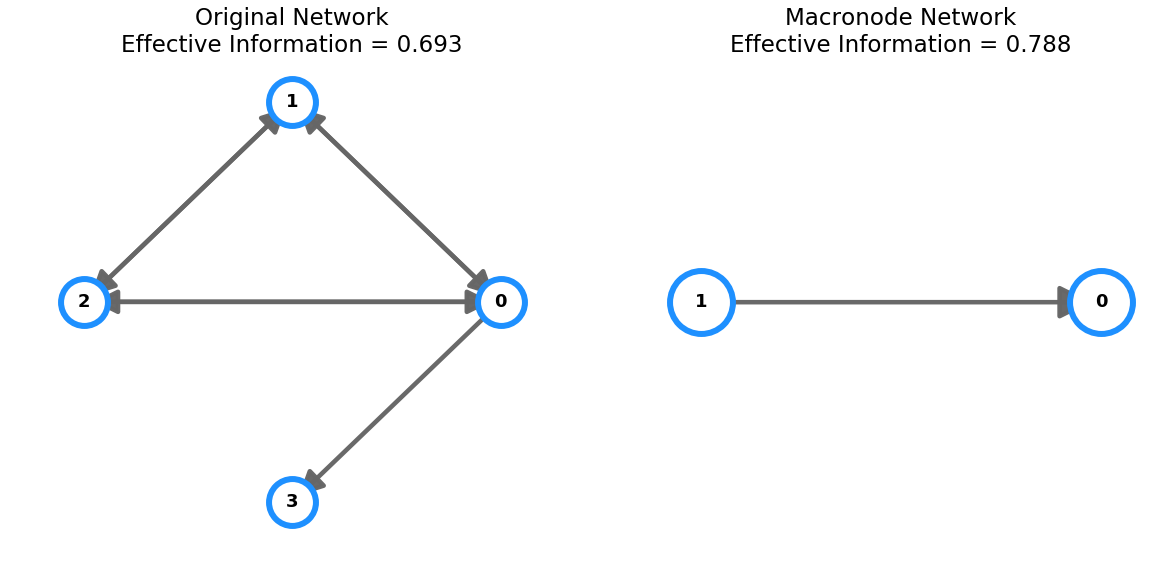

In [13]:
tpm = np.array([[1/4, 1/4, 1/4, 1/4],
                [1/3, 1/3, 1/3, 0],
                [1/3, 1/3, 1/3, 0],
                [0, 0., 0., 1]])

mG, mapping, G_orig = causal_emergence(tpm,p0)

ns = 2000
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,9))
pos = nx.circular_layout(G_orig)
nx.draw_networkx_nodes(G_orig, pos, node_color='w', node_size=ns, 
                       linewidths=3, ax=ax0).set_edgecolor('#333333')
for eij in G_orig.edges():
    i = eij[0]
    j = eij[1]
    if i==j:
        nx.draw_networkx_nodes(G_orig, pos, nodelist=[i], node_size=ns+ns*.1, node_color='w', 
                       linewidths=6, ax=ax0).set_edgecolor('dodgerblue')

nx.draw_networkx_edges(G_orig, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax0, arrowsize=50)
title = "Original Network\nEffective Information = %.3f"%(np.round(get_ei(G_orig,p0),5))
nx.draw_networkx_labels(G_orig, pos, font_size=18, font_color='k', font_weight='bold', ax=ax0)
ax0.set_title(title, size=23)
ax0.axis('off')

ns = 2000
pos = nx.circular_layout(mG)
nx.draw_networkx_nodes(mG, pos, node_color='w', node_size=ns*1.8, 
                       linewidths=3, ax=ax1).set_edgecolor('#333333')
nx.draw_networkx_edges(mG, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax1, arrowsize=70)
for eij in mG.edges():
    i = eij[0]
    j = eij[1]
    if i==j:
        nx.draw_networkx_nodes(mG, pos, nodelist=[i], node_size=(ns+ns*.1)*1.8, node_color='w',
                       linewidths=6, ax=ax1).set_edgecolor('dodgerblue')

title = "Macronode Network\nEffective Information = %.3f"%(np.round(get_ei(mG,p0),5))
nx.draw_networkx_labels(mG, pos, font_size=18, font_color='k', font_weight='bold', ax=ax1)
ax1.set_title(title, size=23)
ax1.axis('off')

plt.show()

The original mapping is 	 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
The best macro-mapping is	 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 10, 7: 10, 8: 10, 9: 10}
The amount of causal emergence is: 0.1593


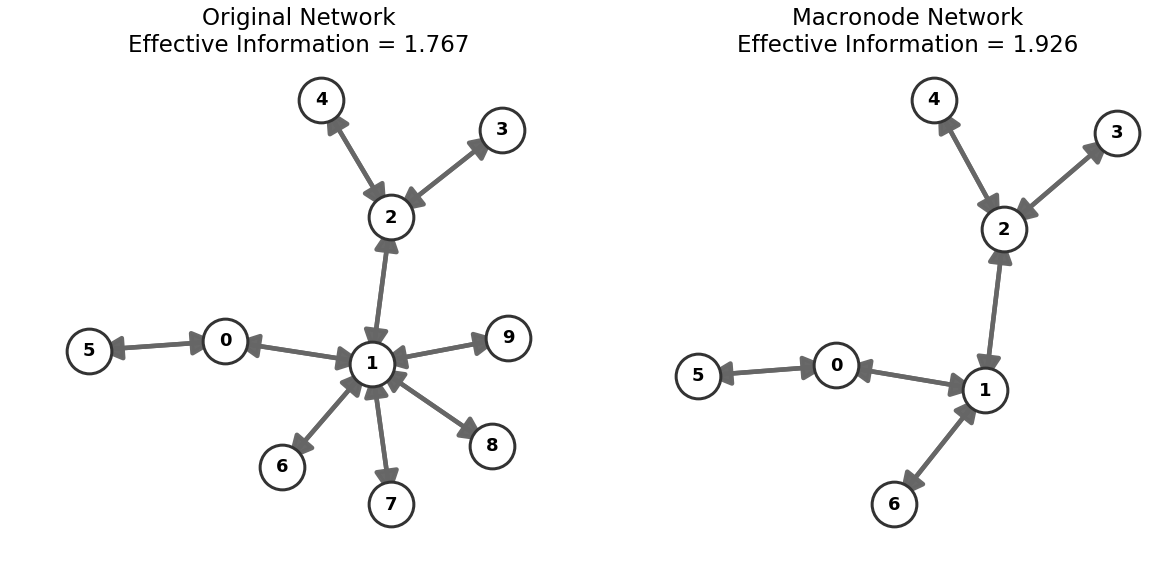

In [14]:
p0 = 0
# n_cliques = 4
# tpm = nx.ring_of_cliques(n_cliques, 20)
# tpm = nx.erdos_renyi_graph(10,.2)
# while not nx.is_connected(tpm):
#     tpm = nx.erdos_renyi_graph(10,.2)
tpm = nx.barabasi_albert_graph(10,1)
# tpm = np.array([[1, 0, 0, 0],
#                 [0, 0, 1, 0],
#                 [0, 1, 0, 0],
#                 [0, 0, 0, 1]])
# tpm = np.array([[1, 0, 0, 0],
#                 [0, 0, 1, 0],
#                 [0, 1, 0, 0],
#                 [0, 0, 0, 1]])

mG, mapping, G_orig = causal_emergence(tpm,p0)

print("The original mapping is \t", dict(zip(G_orig.nodes(), G_orig.nodes())))
print("The best macro-mapping is\t", mapping)
print("The amount of causal emergence is: %.4f" % -(get_ei(G_orig,p0)-get_ei(mG,p0)))
ns = 2000
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,9))
pos = nx.kamada_kawai_layout(G_orig)
# pos = nx.circular_layout(G_orig)
nx.draw_networkx_nodes(G_orig, pos, node_color='w', node_size=ns, 
                       linewidths=3, ax=ax0).set_edgecolor('#333333')
for eij in G_orig.edges():
    i = eij[0]
    j = eij[1]
    if i==j:
        nx.draw_networkx_nodes(G_orig, pos, nodelist=[i], node_size=ns+ns*.1, node_color='w', 
                       linewidths=6, ax=ax0).set_edgecolor('dodgerblue')

nx.draw_networkx_edges(G_orig, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax0, arrowsize=50)
title = "Original Network\nEffective Information = %.3f"%(np.round(get_ei(G_orig,p0),5))
nx.draw_networkx_labels(G_orig, pos, font_size=18, font_color='k', font_weight='bold', ax=ax0)
ax0.set_title(title, size=23)
ax0.axis('off')

ns = 2000
pos = nx.kamada_kawai_layout(G_orig)
# pos = nx.circular_layout(G_orig)
# nx.draw_networkx_nodes(mG, pos, node_color='w', node_size=ns*1.8, 
nx.draw_networkx_nodes(mG, pos, node_color='w', node_size=ns, 
                       linewidths=3, ax=ax1).set_edgecolor('#333333')
nx.draw_networkx_edges(mG, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax1, arrowsize=50)
# nx.draw_networkx_edges(mG, pos, edge_color="#666666",width=4.55, alpha=0.98, ax=ax1, arrowsize=70)
for eij in mG.edges():
    i = eij[0]
    j = eij[1]
    if i==j:
        nx.draw_networkx_nodes(mG, pos, nodelist=[i], node_size=(ns+ns*.1)*1.8, node_color='w',
                       linewidths=6, ax=ax1).set_edgecolor('dodgerblue')



title = "Macronode Network\nEffective Information = %.3f"%(np.round(get_ei(mG,p0),5))
nx.draw_networkx_labels(mG, pos, font_size=18, font_color='k', font_weight='bold', ax=ax1)
ax1.set_title(title, size=23)
ax1.axis('off')

plt.show()

In [15]:
def random_tree(n, seed=None):
    """Returns a uniformly random tree on `n` nodes.

    Parameters
    ----------
    n : int
        A positive integer representing the number of nodes in the tree.
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    NetworkX graph
        A tree, given as an undirected graph, whose nodes are numbers in
        the set {0, …, *n* - 1}.

    Raises
    ------
    NetworkXPointlessConcept
        If `n` is zero (because the null graph is not a tree).

    Notes
    -----
    The current implementation of this function generates a uniformly
    random Prüfer sequence then converts that to a tree via the
    :func:`~networkx.from_prufer_sequence` function. Since there is a
    bijection between Prüfer sequences of length *n* - 2 and trees on
    *n* nodes, the tree is chosen uniformly at random from the set of
    all trees on *n* nodes.

    """
    if n == 0:
        raise nx.NetworkXPointlessConcept('the null graph is not a tree')
    # Cannot create a Prüfer sequence unless `n` is at least two.
    if n == 1:
        return nx.empty_graph(1)
    sequence = [np.random.choice(range(n)) for i in range(n - 2)]
    return nx.from_prufer_sequence(sequence)

In [16]:
# Trees vs BA networks
cols = ["#7fb546","#b55bc3","#5db488","#c7608b","#bd9846","#7081ce","#cb5a42"]


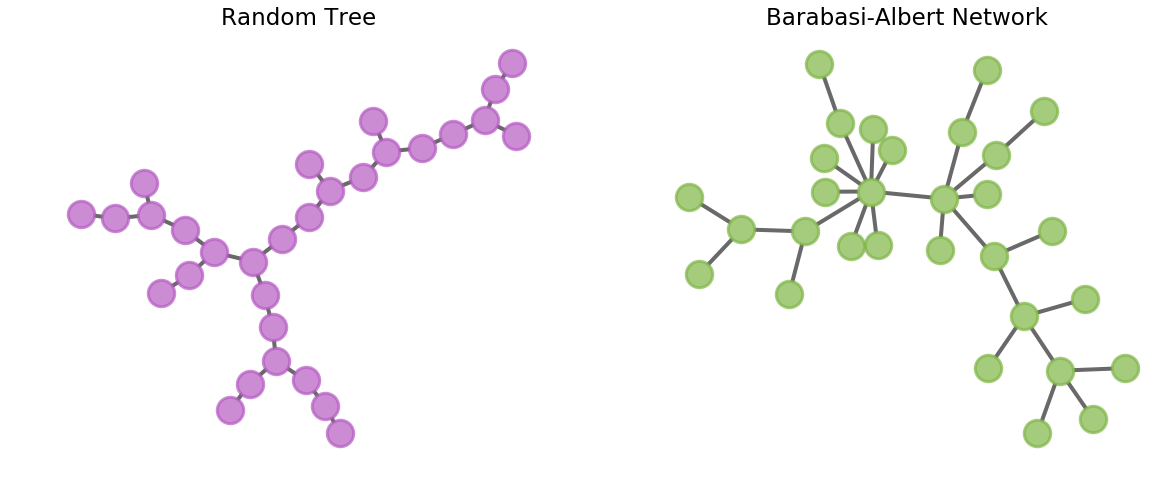

In [17]:
ns = 700
N = 30
Gba = nx.barabasi_albert_graph(N,1)
Gtr = random_tree(N,1)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))
pos = nx.kamada_kawai_layout(Gtr)
nx.draw_networkx_nodes(Gtr, pos, node_color='w', node_size=ns*.95, linewidths=0, ax=ax0).set_edgecolor(cols[1])
nx.draw_networkx_nodes(Gtr, pos, node_color=cols[1], node_size=ns, linewidths=3, alpha=0.7, ax=ax0).set_edgecolor(cols[1])
nx.draw_networkx_edges(Gtr, pos, edge_color="#666666",width=4.0, alpha=0.98, ax=ax0, arrowsize=50)

title = "Random Tree"
# nx.draw_networkx_labels(Gtr, pos, font_size=18, font_color='k', font_weight='bold', ax=ax0)
ax0.set_title(title, size=23)
ax0.axis('off')

pos = nx.kamada_kawai_layout(Gba)
nx.draw_networkx_nodes(Gba, pos, node_color='w', node_size=ns, linewidths=0, ax=ax1).set_edgecolor(cols[0])
nx.draw_networkx_nodes(Gba, pos, node_color=cols[0], node_size=ns, linewidths=3, alpha=0.7, ax=ax1).set_edgecolor(cols[0])
nx.draw_networkx_edges(Gba, pos, edge_color="#666666",width=4.0, alpha=0.98, ax=ax1, arrowsize=50)

title = "Barabasi-Albert Network"
# nx.draw_networkx_labels(Gba, pos, font_size=18, font_color='k', font_weight='bold', ax=ax1)
ax1.set_title(title, size=23)
ax1.axis('off')

# plt.savefig("../figs/pngs/randomtree_vs_ba.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/randomtree_vs_ba.pdf", bbox_inches='tight')
plt.show()

In [18]:
def preferential_attachment_network(N,alpha=1.0,m=1):
    """
    sublinear, linear, or superlinear preferential attachment
    """
    G = nx.Graph()
    G.add_edge(0,1)
    for node_i in range(2,N):
        degrees = np.array(list(dict(G.degree()).values()))
        probs = (degrees**alpha) / sum(degrees**alpha)
        G.add_edge(node_i,np.random.choice(range(G.number_of_nodes()), p=probs))
    
    return G

In [18]:
min_alpha = 0
max_alpha = 2
min_N = 10
max_N = 200

m = 1

num_i = 10
num_N = 50
num_a = 9

alphas = np.linspace(min_alpha,max_alpha, num_a)
# pa_alpha = {}

In [21]:
for alpha in alphas:
    pa_ce = {}
    Ns = np.random.choice(list(range(min_N, max_N)), size=num_N, replace=False)
    for N in Ns:
        print("alpha=%.4f, N=%i"%(alpha,N), dt.datetime.now())
        pa_tr1 = []
        for i in range(num_i):
            G = preferential_attachment_network(N, alpha, m)
            try:
                mG, mapping, G_orig = causal_emergence(G,p0)
            except:
                continue

            if get_ei(mG, p0) > get_ei(G_orig, p0):
                pa_tr1.append(mG.number_of_nodes())

        pa_ce[N] = pa_tr1
    
    pa_alpha[alpha] = pa_ce

alpha=0.0000, N=105 2018-12-07 11:32:37.230463
alpha=0.0000, N=185 2018-12-07 11:33:18.105746
alpha=0.0000, N=60 2018-12-07 11:35:32.423888
alpha=0.0000, N=28 2018-12-07 11:35:53.562598
alpha=0.0000, N=108 2018-12-07 11:35:57.977873
alpha=0.0000, N=35 2018-12-07 11:36:52.887068
alpha=0.0000, N=127 2018-12-07 11:36:59.229899
alpha=0.0000, N=21 2018-12-07 11:38:06.861377
alpha=0.0000, N=25 2018-12-07 11:38:09.078143
alpha=0.0000, N=89 2018-12-07 11:38:12.191383
alpha=0.0000, N=117 2018-12-07 11:38:52.800221
alpha=0.0000, N=165 2018-12-07 11:39:33.861864
alpha=0.0000, N=196 2018-12-07 11:40:59.112931
alpha=0.0000, N=176 2018-12-07 11:43:20.347968
alpha=0.0000, N=177 2018-12-07 11:45:50.446569
alpha=0.0000, N=146 2018-12-07 11:47:56.972397
alpha=0.0000, N=120 2018-12-07 11:49:18.654590
alpha=0.0000, N=155 2018-12-07 11:50:13.774515
alpha=0.0000, N=143 2018-12-07 11:51:39.075972
alpha=0.0000, N=121 2018-12-07 11:53:22.311084
alpha=0.0000, N=188 2018-12-07 11:54:21.906533
alpha=0.0000, N=32 

alpha=0.7500, N=178 2018-12-07 14:29:16.195742
alpha=0.7500, N=11 2018-12-07 14:32:02.584524
alpha=0.7500, N=50 2018-12-07 14:32:03.339827
alpha=0.7500, N=101 2018-12-07 14:32:18.414982
alpha=0.7500, N=67 2018-12-07 14:33:04.812751
alpha=0.7500, N=76 2018-12-07 14:33:27.640495
alpha=0.7500, N=134 2018-12-07 14:34:08.555579
alpha=0.7500, N=109 2018-12-07 14:35:56.136506
alpha=0.7500, N=176 2018-12-07 14:36:51.369564
alpha=0.7500, N=131 2018-12-07 14:39:27.248745
alpha=0.7500, N=44 2018-12-07 14:40:43.224554
alpha=0.7500, N=166 2018-12-07 14:40:55.077949
alpha=0.7500, N=65 2018-12-07 14:43:02.645806
alpha=0.7500, N=148 2018-12-07 14:43:22.169326
alpha=0.7500, N=115 2018-12-07 14:44:59.696194
alpha=0.7500, N=35 2018-12-07 14:46:07.641856
alpha=0.7500, N=83 2018-12-07 14:46:14.550769
alpha=0.7500, N=160 2018-12-07 14:46:50.876450
alpha=0.7500, N=59 2018-12-07 14:49:25.494704
alpha=0.7500, N=106 2018-12-07 14:49:43.794247
alpha=0.7500, N=142 2018-12-07 14:51:00.441614
alpha=0.7500, N=16 201

alpha=1.7500, N=111 2018-12-08 05:26:39.853703
alpha=1.7500, N=50 2018-12-08 05:31:42.306233
alpha=1.7500, N=102 2018-12-08 05:32:13.854328
alpha=1.7500, N=34 2018-12-08 05:36:44.171289
alpha=1.7500, N=100 2018-12-08 05:36:55.803490
alpha=1.7500, N=46 2018-12-08 05:40:58.811420
alpha=1.7500, N=69 2018-12-08 05:41:23.588150
alpha=1.7500, N=127 2018-12-08 05:42:42.041344
alpha=1.7500, N=82 2018-12-08 05:51:20.924957
alpha=1.7500, N=64 2018-12-08 05:53:49.980210
alpha=1.7500, N=148 2018-12-08 05:55:05.043191
alpha=1.7500, N=161 2018-12-08 06:06:20.858853
alpha=1.7500, N=119 2018-12-08 06:25:31.838679
alpha=1.7500, N=186 2018-12-08 06:33:26.259107
alpha=1.7500, N=44 2018-12-08 07:03:09.067019
alpha=1.7500, N=37 2018-12-08 07:03:35.551493
alpha=1.7500, N=199 2018-12-08 07:03:52.274109
alpha=1.7500, N=107 2018-12-08 07:36:53.201191
alpha=1.7500, N=125 2018-12-08 07:41:48.427281
alpha=1.7500, N=154 2018-12-08 07:49:52.852745
alpha=1.7500, N=191 2018-12-08 08:00:49.003655
alpha=1.7500, N=116 2

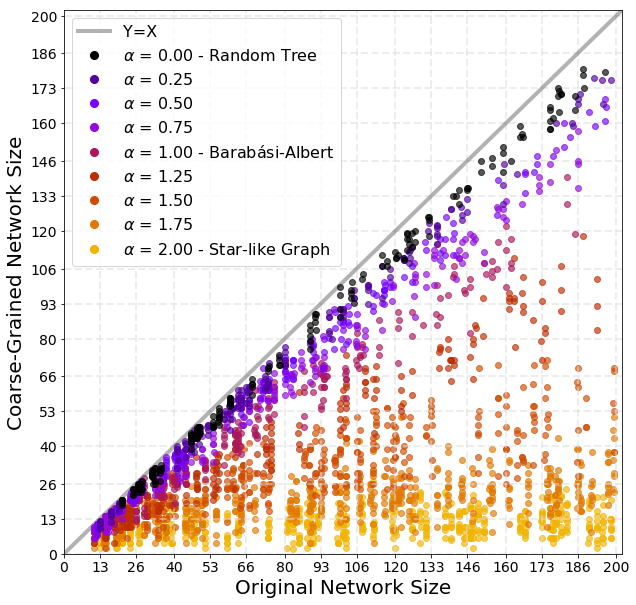

In [23]:
plt.figure(figsize=(10,10))

alphas = np.array(list(pa_alpha.keys()))
cols = plt.cm.gnuplot(np.array(list(range(num_a)))/(max(np.array(list(range(num_a))))+1))

i = 0
for alpha in alphas:
    for N in pa_alpha[alpha].keys():
        y = pa_alpha[alpha][N]
        if y:
            plt.plot([N]*len(y) + np.random.uniform(-0.15,0.15,len(y)), 
                              y + np.random.uniform(-0.05,0.05,len(y)), 
                    linestyle="", marker='.', markersize=12, color=cols[i], alpha=0.65, zorder=7-i)
    i += 1

plt.plot([0,max_N+min_N], [0,max_N+min_N], linestyle="-", linewidth=4.0, color='#666666', label='Y=X', alpha=0.5)
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[0], label=r'$\alpha$ = %.2f - Random Tree'%alphas[0])
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[1], label=r'$\alpha$ = %.2f'%alphas[1])
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[2], label=r'$\alpha$ = %.2f'%alphas[2])
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[3], label=r'$\alpha$ = %.2f'%alphas[3])
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[4], label=r'$\alpha$ = %.2f - Barabási-Albert'%alphas[4])
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[5], label=r'$\alpha$ = %.2f'%alphas[5])
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[6], label=r'$\alpha$ = %.2f'%alphas[6])
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[7], label=r'$\alpha$ = %.2f'%alphas[7])
plt.plot([-100], [-100], linestyle="", marker='o', 
         markersize=8.0, color=cols[8], label=r'$\alpha$ = %.2f - Star-like Graph'%alphas[8])

plt.xlabel("Original Network Size", size=20)
plt.ylabel("Coarse-Grained Network Size", size=20)

plt.grid(color='gainsboro', linestyle='--', linewidth=2, alpha=0.5)
plt.xlim(0,max_N+2)
plt.ylim(0,max_N+2)
plt.xticks(np.linspace(0,max_N,16,dtype=int), fontsize=14)
plt.yticks(np.linspace(0,max_N,16,dtype=int), fontsize=14)
plt.legend(fontsize=16, framealpha=0.8)

plt.savefig("../figs/pngs/CausalEmergence_pa_alpha.png", dpi=425, bbox_inches='tight')
plt.savefig("../figs/pdfs/CausalEmergence_pa_alpha.pdf", bbox_inches='tight')
plt.show()

In [27]:
out_df = pd.DataFrame(columns=['alpha', 'ce_size'])

for alpha in pa_alpha.keys():
    curr = pa_alpha[alpha]
    for Nmicro in curr.keys():
        Nmacro_list = curr[Nmicro]
        for Nmacro in Nmacro_list:
            dat = {'alpha':[alpha], 'ce_size':[Nmacro/Nmicro]}
            out_df = out_df.append(pd.DataFrame(dat))
            
out_df.groupby('alpha').mean()

,ce_size
alpha,
0.00,0.922271
0.25,0.889918
0.50,0.850906
0.75,0.785284
1.00,0.701582
1.25,0.593320
1.50,0.397994
1.75,0.238317
2.00,0.129845


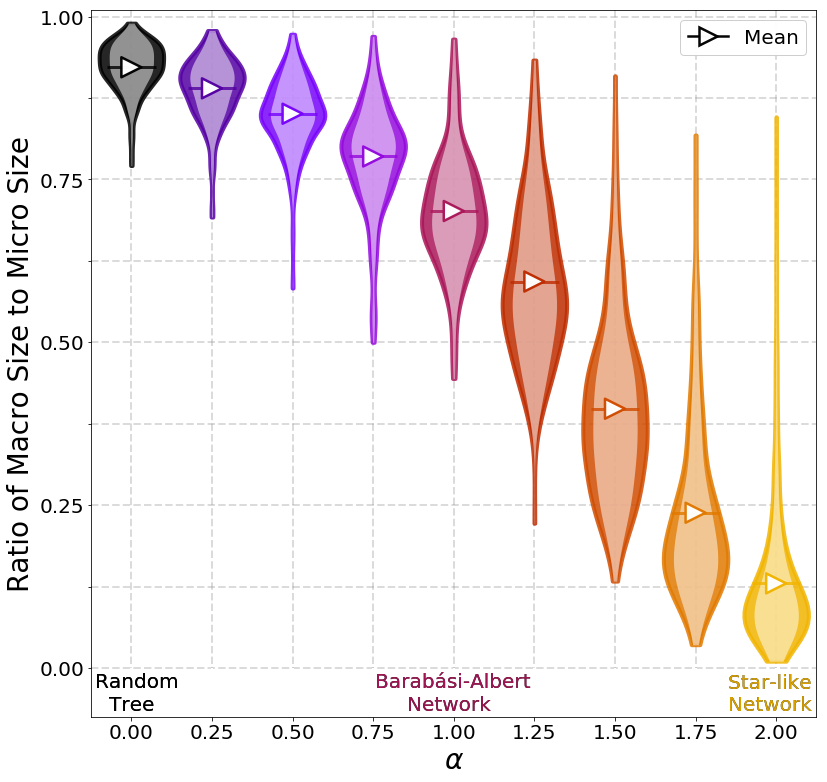

In [164]:
plt.rc('axes', axisbelow=True)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

for i in range(len(pa_alpha.keys())):
    alpha = list(pa_alpha.keys())[i]
    dat = out_df[out_df['alpha']==alpha]
    parts = ax.violinplot(dat['ce_size'], positions=[i+1], showmeans=False, 
                          showmedians=False, showextrema=False, widths=0.8)
    pc = parts['bodies'][0]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor(cols[i])
    pc.set_alpha(0.85)
    pc.set_linewidth(4.0)
    parts = ax.violinplot(dat['ce_size'], positions=[i+1], showmeans=False, 
                          showmedians=False, showextrema=False, widths=0.55)
    pc = parts['bodies'][0]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor('w')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.0)
    
plt.hlines(list(out_df.groupby('alpha').mean()['ce_size']), 
           np.linspace(0.7, 8.7, 9), np.linspace(1.3, 9.3, 9), 
           colors=cols, zorder=1, linewidth=3, alpha=0.8)

plt.scatter(range(1,10), list(out_df.groupby('alpha').mean()['ce_size']), marker='>', s=400, 
            facecolor='w', edgecolors=cols, linewidth=2.5, alpha=0.98)
plt.plot([-10],[-10], marker='>', markersize=18, markerfacecolor='w', color='k',
         markeredgecolor='k', markeredgewidth=2.5, alpha=0.98, label='Mean', linewidth=2.5)
plt.vlines([y+1 for y in range(len(pa_alpha.keys()))], -0.75, 0, color='w', linewidth=2.0)

ax.set_ylabel('Ratio of Macro Size to Micro Size', fontsize=28)
ax.set_xlabel(r'$\alpha$', fontsize=28)
ax.set_xticks([y+1 for y in range(len(pa_alpha.keys()))])
ax.set_xticklabels(["%.2f"%i for i in pa_alpha.keys()], fontsize=20)
ax.set_yticks(np.linspace(0,1,9))
ax.set_yticklabels(['0.00', '', '0.25', '', '0.50', '', '0.75', '', '1.00'], fontsize=20)
ax.grid(True, linestyle='--', linewidth=2.0, color='#999999', alpha=0.35)

ax.text(0.55,-.030,"Random", fontsize=20, color='k')
ax.text(0.72,-.065,"Tree", fontsize=20, color='k')
ax.text(4.02,-.030,"Barabási-Albert", fontsize=20, color='k')
ax.text(4.42,-.065,"Network", fontsize=20, color='k')
ax.text(8.40,-.065,"Star-like \nNetwork", fontsize=20, color='k')
ax.text(0.55,-.030,"Random", fontsize=20, color=cols[0], alpha=0.95)
ax.text(0.72,-.065,"Tree", fontsize=20, color=cols[0], alpha=0.95)
ax.text(4.02,-.030,"Barabási-Albert", fontsize=20, color=cols[4], alpha=0.95)
ax.text(4.42,-.065,"Network", fontsize=20, color=cols[4], alpha=0.9)
ax.text(8.40,-.065,"Star-like \nNetwork", fontsize=20, color=cols[8], alpha=0.9)

leg1 = ax.legend(fontsize=20, framealpha=0.95)
ax.set_ylim(-0.075, 1.01)
ax.set_xlim(0.5, 9.5)

# plt.savefig("../figs/pngs/CausalEmergence_N_violin_pa_alpha.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/CausalEmergence_N_violin_pa_alpha.pdf", bbox_inches='tight')
plt.show()

In [62]:
min_alpha = 0
max_alpha = 2
min_N = 10
max_N = 100

m = 1

num_i = 10
num_N = 40
num_a = 9

alphas = np.linspace(min_alpha,max_alpha, num_a)
pa_alpha_ce = {}
pa_alpha_nN = {}

for alpha in alphas:
    pa_ce = {}
    pa_nN = {}
    Ns = np.random.choice(list(range(min_N, max_N)), size=num_N, replace=False)
    for N in Ns:
        print("alpha=%.4f, N=%i"%(alpha,N), dt.datetime.now())
        pa_tr1 = []
        pa_nN1 = []
        for i in range(num_i):
            G = preferential_attachment_network(N, alpha, m)
            try:
                mG, mapping, G_orig = causal_emergence(G,p0)
            except:
                continue
            
            mac_ei = get_ei(mG, p0)
            mic_ei = get_ei(G_orig, p0)
            if mac_ei > mic_ei:
                pa_tr1.append(mG.number_of_nodes())
            pa_nN1.append(mic_ei - mac_ei)

        pa_ce[N] = pa_tr1
        pa_nN[N] = pa_nN1
    
    pa_alpha_ce[alpha] = pa_ce
    pa_alpha_nN[alpha] = pa_nN

alpha=0.0000, N=55 2018-12-09 17:24:38.313265
alpha=0.0000, N=48 2018-12-09 17:24:52.722108
alpha=0.0000, N=35 2018-12-09 17:25:02.319862
alpha=0.0000, N=59 2018-12-09 17:25:07.650032
alpha=0.0000, N=65 2018-12-09 17:25:24.475066
alpha=0.0000, N=96 2018-12-09 17:25:46.166691
alpha=0.0000, N=74 2018-12-09 17:26:27.598392
alpha=0.0000, N=62 2018-12-09 17:26:54.004650
alpha=0.0000, N=76 2018-12-09 17:27:10.947694
alpha=0.0000, N=83 2018-12-09 17:27:30.779836
alpha=0.0000, N=82 2018-12-09 17:27:59.458154
alpha=0.0000, N=34 2018-12-09 17:28:26.487750
alpha=0.0000, N=98 2018-12-09 17:28:31.185490
alpha=0.0000, N=90 2018-12-09 17:29:14.469599
alpha=0.0000, N=94 2018-12-09 17:29:52.525062
alpha=0.0000, N=84 2018-12-09 17:30:35.364481
alpha=0.0000, N=17 2018-12-09 17:31:05.933191
alpha=0.0000, N=89 2018-12-09 17:31:07.442534
alpha=0.0000, N=88 2018-12-09 17:31:40.704399
alpha=0.0000, N=77 2018-12-09 17:32:07.482484
alpha=0.0000, N=33 2018-12-09 17:32:33.133207
alpha=0.0000, N=57 2018-12-09 17:3

alpha=1.0000, N=66 2018-12-09 18:13:33.315815
alpha=1.0000, N=65 2018-12-09 18:13:58.521334
alpha=1.0000, N=44 2018-12-09 18:14:24.712374
alpha=1.0000, N=46 2018-12-09 18:14:36.953410
alpha=1.0000, N=27 2018-12-09 18:14:50.521359
alpha=1.0000, N=94 2018-12-09 18:14:54.984653
alpha=1.0000, N=91 2018-12-09 18:15:40.180070
alpha=1.0000, N=48 2018-12-09 18:16:26.948799
alpha=1.0000, N=79 2018-12-09 18:16:41.618140
alpha=1.0000, N=89 2018-12-09 18:17:23.101438
alpha=1.0000, N=88 2018-12-09 18:17:56.816632
alpha=1.0000, N=45 2018-12-09 18:18:44.524510
alpha=1.0000, N=87 2018-12-09 18:18:55.700669
alpha=1.0000, N=21 2018-12-09 18:19:35.792033
alpha=1.0000, N=34 2018-12-09 18:19:38.223715
alpha=1.0000, N=95 2018-12-09 18:19:44.900933
alpha=1.0000, N=47 2018-12-09 18:20:34.373741
alpha=1.0000, N=19 2018-12-09 18:20:48.381102
alpha=1.0000, N=78 2018-12-09 18:20:50.208197
alpha=1.0000, N=41 2018-12-09 18:21:31.257143
alpha=1.0000, N=14 2018-12-09 18:21:41.525172
alpha=1.2500, N=38 2018-12-09 18:2

alpha=2.0000, N=59 2018-12-09 20:55:53.477093
alpha=2.0000, N=47 2018-12-09 20:56:58.993554


In [63]:
out_df_ce = pd.DataFrame(columns=['alpha', 'ce'])

for alpha in pa_alpha_nN.keys():
    curr = pa_alpha_nN[alpha]
    for Nmicro in curr.keys():
        Nmacro_list = curr[Nmicro]
        for Nmacro in Nmacro_list:
            dat = {'alpha':[alpha], 'ce':[Nmacro]}
            out_df_ce = out_df_ce.append(pd.DataFrame(dat))
            
# out_df_ce.groupby('alpha').mean()

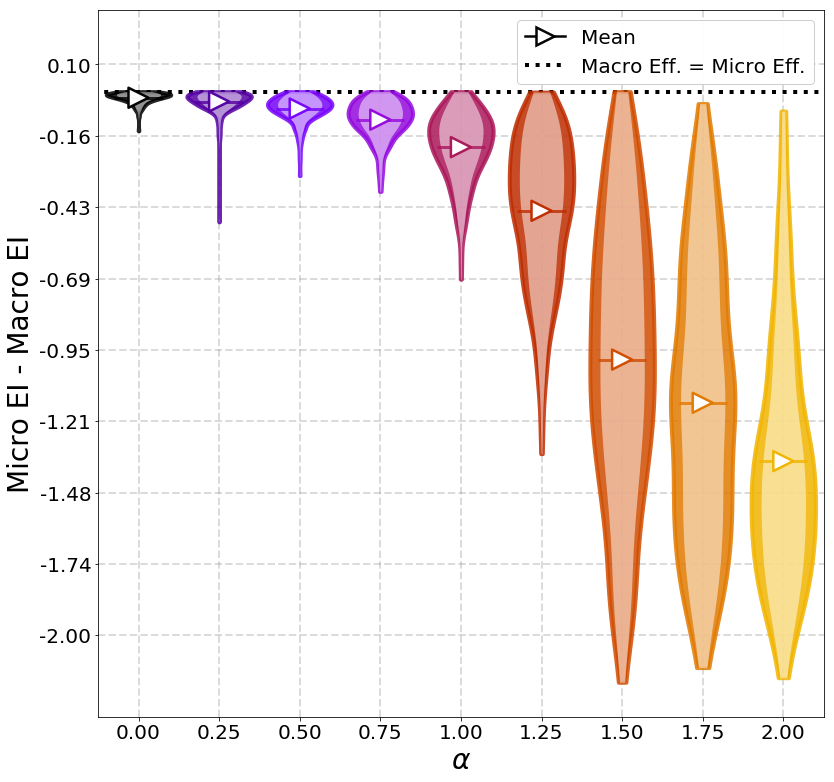

In [64]:
cols = plt.cm.gnuplot(np.array(list(range(len(alphas))))/(max(np.array(list(range(len(alphas)))))+1))
plt.rc('axes', axisbelow=True)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

plt.hlines(0, -1, 10, linestyle=":", zorder=1, linewidth=4.0, label='Macro Eff. = Micro Eff.')

for i in range(len(pa_alpha_ce.keys())):
    alpha = list(pa_alpha_ce.keys())[i]
    dat = out_df_ce[out_df_ce['alpha']==alpha]
    parts = ax.violinplot(dat['ce'], positions=[i+1], showmeans=False, 
                          showmedians=False, showextrema=False, widths=0.8)
    pc = parts['bodies'][0]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor(cols[i])
    pc.set_alpha(0.85)
    pc.set_linewidth(4.0)
    parts = ax.violinplot(dat['ce'], positions=[i+1], showmeans=False, 
                          showmedians=False, showextrema=False, widths=0.55)
    pc = parts['bodies'][0]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor('w')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.0)
    
plt.hlines(list(out_df_ce.groupby('alpha').mean()['ce']), 
           np.linspace(0.7, 8.7, 9), np.linspace(1.3, 9.3, 9), 
           colors=cols, zorder=1, linewidth=3, alpha=0.8)

plt.scatter(range(1,(len(alphas)+1)), list(out_df_ce.groupby('alpha').mean()['ce']), marker='>', s=400, 
            facecolor='w', edgecolors=cols, linewidth=2.5, alpha=0.98)
plt.plot([-10],[-10], marker='>', markersize=18, markerfacecolor='w', color='k',
         markeredgecolor='k', markeredgewidth=2.5, alpha=0.98, label='Mean', linewidth=2.5)
# plt.vlines([y+1 for y in range(len(pa_alpha_ce.keys()))], -0.75, 0, color='w', linewidth=2.0)

# ax.set_ylabel('Ratio of Macro Size to Micro Size', fontsize=28)
ax.set_ylabel('Micro EI - Macro EI', fontsize=28)
ax.set_xlabel(r'$\alpha$', fontsize=28)
ax.set_xticks([y+1 for y in range(len(alphas))])
ax.set_xticklabels(["%.2f"%i for i in alphas], fontsize=20)
ax.set_yticks(np.linspace(0.1,-2,9))
ax.set_yticklabels(["%.2f"%i for i in np.linspace(0.1,-2,9)], fontsize=20)
ax.grid(True, linestyle='--', linewidth=2.0, color='#999999', alpha=0.35)

# ax.text(0.55,-.030,"Random", fontsize=20, color='k')
# ax.text(0.72,-.065,"Tree", fontsize=20, color='k')
# ax.text(4.02,-.030,"Barabási-Albert", fontsize=20, color='k')
# ax.text(4.42,-.065,"Network", fontsize=20, color='k')
# ax.text(8.40,-.065,"Star-like \nNetwork", fontsize=20, color='k')
# ax.text(0.55,-.030,"Random", fontsize=20, color=cols[0], alpha=0.95)
# ax.text(0.72,-.065,"Tree", fontsize=20, color=cols[0], alpha=0.95)
# ax.text(4.02,-.030,"Barabási-Albert", fontsize=20, color=cols[4], alpha=0.95)
# ax.text(4.42,-.065,"Network", fontsize=20, color=cols[4], alpha=0.9)
# ax.text(8.40,-.065,"Star-like \nNetwork", fontsize=20, color=cols[8], alpha=0.9)

leg1 = ax.legend(fontsize=20, framealpha=0.95)
ax.set_ylim(-2.3, 0.3)
ax.set_xlim(0.5, 9.5)

plt.savefig("../figs/pngs/CausalEmergence_ce_violin_pa_alpha.png", dpi=425, bbox_inches='tight')
plt.savefig("../figs/pdfs/CausalEmergence_ce_violin_pa_alpha.pdf", bbox_inches='tight')
plt.show()

In [94]:
pa_alpha_frac = pa_alpha.copy()

In [97]:
np.array(pa_alpha[alpha][N])/N

array([ 0.12244898,  0.2244898 ,  0.26530612,  0.20408163,  0.14285714,
        0.30612245,  0.2244898 ,  0.16326531,  0.30612245,  0.26530612,
        0.24489796,  0.18367347,  0.12244898,  0.16326531,  0.32653061,
        0.04081633,  0.12244898,  0.34693878,  0.24489796,  0.20408163])

In [98]:
pa_alpha_frac = {}
for alpha in pa_alpha.keys():
    alpha_frac = []
    for N in pa_alpha[alpha].keys():
        y = np.array(pa_alpha[alpha][N])/N
        for i in y:
            alpha_frac.append(i)
    pa_alpha_frac[alpha] = alpha_frac

In [115]:
import joypy


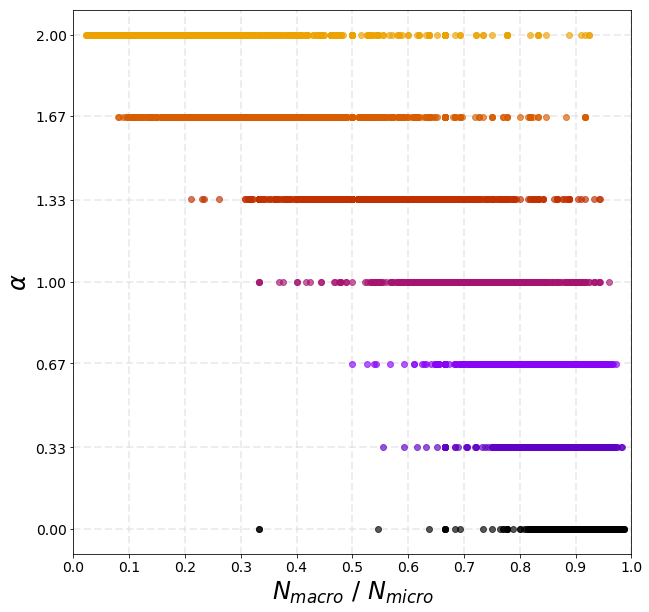

In [174]:
# cols = ["#fe7d43","#934acd","#5a9046","#b74c8e","#6574bd","#c44a45"]
# cols = ["#7fb546","#b55bc3","#5db488","#c7608b","#bd9846","#7081ce","#cb5a42"]
Ns = list(pa_alpha[0].keys())
plt.figure(figsize=(10,10))
alphas = np.array(list(pa_alpha.keys()))
cols = plt.cm.gnuplot(np.array(list(range(7)))/(max(np.array(list(range(7))))+1))
i = 0
for alpha in alphas:
    frac = pa_alpha_frac[alpha]
    plt.plot(frac, [alpha]*len(frac), linestyle="", marker='.', markersize=12, color=cols[i], alpha=0.65)
#     plt.plot([alpha]*len(frac), frac, linestyle="", marker='.', markersize=12, color=cols[i], alpha=0.65)
    i += 1

# plt.plot(Ns, Ns**.5)
# plt.plot([0,max(Ns)+min(Ns)], [0,max(Ns)+min(Ns)], linestyle="-", linewidth=4.0,
#          color='#666666', label='Y=X', alpha=0.5)
plt.plot([-100], [-100], linestyle="", marker='o', markersize=8.0, color=cols[0], label=r'$\alpha$ = %.2f - Random Tree'%alphas[0])
plt.plot([-100], [-100], linestyle="", marker='o', markersize=8.0, color=cols[1], label=r'$\alpha$ = %.2f'%alphas[1])
plt.plot([-100], [-100], linestyle="", marker='o', markersize=8.0, color=cols[2], label=r'$\alpha$ = %.2f'%alphas[2])
plt.plot([-100], [-100], linestyle="", marker='o', markersize=8.0, color=cols[3], label=r'$\alpha$ = %.2f - Barabási-Albert'%alphas[3])
plt.plot([-100], [-100], linestyle="", marker='o', markersize=8.0, color=cols[4], label=r'$\alpha$ = %.2f'%alphas[4])
plt.plot([-100], [-100], linestyle="", marker='o', markersize=8.0, color=cols[5], label=r'$\alpha$ = %.2f'%alphas[5])
plt.plot([-100], [-100], linestyle="", marker='o', markersize=8.0, color=cols[6], label=r'$\alpha$ = %.2f - Star-like Graph'%alphas[6])

plt.ylabel(r"$\alpha$", size=24)
plt.xlabel(r"$N_{macro}$ / $N_{micro}$", size=24)

plt.grid(color='gainsboro', linestyle='--', linewidth=2, alpha=0.5)
plt.ylim(-0.1,2.1)
plt.xlim(0,1)
plt.yticks(np.round(np.linspace(0,2.0,7),2), fontsize=14)
plt.xticks(np.round(np.linspace(0,1.0,11),2), fontsize=14)
# plt.xlim(0,max(Ns)+2)
# plt.ylim(0,max(Ns)+2)
# plt.xticks(np.linspace(0,max(Ns),16,dtype=int), fontsize=14)
# plt.yticks(np.linspace(0,max(Ns),16,dtype=int), fontsize=14)
# plt.legend(fontsize=16, framealpha=0.8)

# plt.savefig("../figs/pngs/causalemergence_alpha_nonjoy.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/causalemergence_alpha_nonjoy.pdf", bbox_inches='tight')
plt.show()

In [142]:
pa_frac = {}
for alpha in range(len(pa_alpha_frac.keys())):
    pa_frac[label_s[alpha]] = pa_alpha_frac[list(pa_alpha_frac.keys())[alpha]]

In [5]:
import numpy as np


array([ 0.00063096,  0.00127717,  0.00258523,  0.00523299,  0.01059254,
        0.02144125,  0.04340103,  0.08785167,  0.17782794])

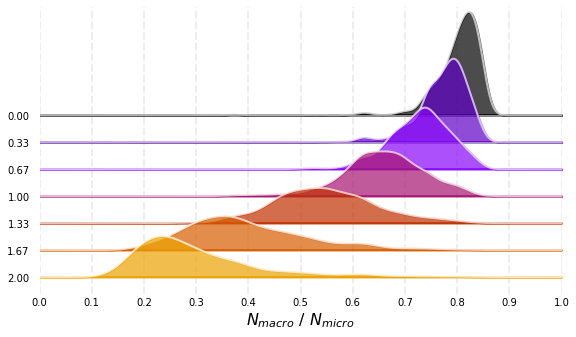

In [173]:
labs = np.round(np.linspace(0,2.0,7),2)
label_s = ["%.2f"%i for i in labs]


fig, axes = joypy.joyplot(pa_frac, by="Name", figsize=(8,4.5),colormap=plt.cm.gnuplot, labels=label_s, 
                          alpha=0.7, ylabelsize=16, overlap=2.,grid=True, linecolor='w', linewidth=2.0)
plt.grid(color='gainsboro', linestyle='--', linewidth=2, alpha=0.5)
plt.ylim(-0.1,2.1)
plt.xlim(0,1)
plt.yticks(np.round(np.linspace(0,2.0,7),2), fontsize=14)
plt.xticks(np.round(np.linspace(0,1.0,11),2))#, fontsize=14)
plt.xlabel(r"$N_{macro}$ / $N_{micro}$", fontsize=16)
# plt.savefig("../figs/pngs/causalemergence_alpha_joyplot.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/causalemergence_alpha_joyplot.pdf", bbox_inches='tight')
# plt.show()

In [ ]:
temp, by="Year", column="Anomaly", labels=labels, range_style='own',
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Global daily temperature 1880-2014 \n(°C above 1950-80 average)",
                          colormap=cm.autumn_r

In [ ]:
ce_ba1 = []
ce_ba2 = []

N = 20
m1 = 1
m2 = 2

for i in range(5000):
    if i % 100==0:
        print(i)
    tpm = nx.barabasi_albert_graph(N,m1)
    try:
        mG, mapping, G_orig = causal_emergence(tpm,p0)
    except:
        pass
    if get_ei(mG,p0) > get_ei(G_orig,p0):
        ce_ba1.append((get_ei(mG,p0) - get_ei(G_orig,p0))/get_ei(G_orig,p0))

    tpm = nx.barabasi_albert_graph(N,m2)
    try:
        mG, mapping, G_orig = causal_emergence(tpm,p0)
    except:
        pass
    if get_ei(mG,p0) > get_ei(G_orig,p0):
        ce_ba2.append((get_ei(mG,p0) - get_ei(G_orig,p0))/get_ei(G_orig,p0))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [ ]:
plt.figure(figsize=(16,9))
plt.hist(ce_ba1, alpha=0.7, bins=20, label='N=20, m=1')
plt.hist(ce_ba2, alpha=0.7, bins=20, label='N=20, m=2')
plt.legend(fontsize=18)
plt.title("BA Networks, same size, different sparsity (m=1 is sparse, m=2 is denser)", size=18)
plt.show()

In [7]:
print("---------------------------------------\n")
tpm = np.array([[1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [0, 0, 0, 1]])

thresh = 0
G = prepare_network(tpm, p0) 
current_ei = get_ei(G, p0)
micro_nodes_left = list(G.nodes())
micros_that_have_been_macroed = []
macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
print("Starting with this tpm:\n",np.round(tpm, 4))
print("\nSearch started... current_ei = %.4f"%current_ei)

np.random.shuffle(micro_nodes_left)
for node_i in micro_nodes_left:
    print("...")

    neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
    for node_j in neighbors_i:
        neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
        neighbors_i = neighbors_j.union(neighbors_i)
    macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
    queue = macros_to_check.copy()

    node_i_macro = macro_mapping[node_i]
    if node_i_macro == node_i:
        node_i_macro = max(list(macro_mapping.values()))+1
    while len(queue) > 0:
        np.random.shuffle(queue)
        possible_macro = queue.pop()

        possible_mapping = macro_mapping.copy()
        possible_mapping[node_i]         = node_i_macro
        possible_mapping[possible_macro] = node_i_macro

        MACRO = get_macro(G, possible_mapping, p0)
        macro_ei = get_ei(MACRO, p0)
        Gm = prepare_network(MACRO, p0=p0)

        if macro_ei - current_ei > thresh:
            current_ei = macro_ei
            macro_mapping = possible_mapping
            print("just found successful macro grouping... current_ei = %.4f"%current_ei)
            
print("\nSearch stopped.")
print("We end up with a final EI = %.4f"%current_ei,"and mapping:",macro_mapping)
print("Ending with this tpm:\n",np.round(get_macro(tpm, macro_mapping),4))

print("---------------------------------------\n")
tpm = np.array([[1/3, 1/3, 1/3, 0],
                [1/3, 1/3, 1/3, 0],
                [1/3, 1/3, 1/3, 0],
                [0, 0., 0., 1]])

thresh = 0
G = prepare_network(tpm, p0) 
current_ei = get_ei(G, p0)
micro_nodes_left = list(G.nodes())
micros_that_have_been_macroed = []
macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
print("Starting with this tpm:\n",np.round(tpm, 4))
print("\nSearch started... current_ei = %.4f"%current_ei)

np.random.shuffle(micro_nodes_left)
for node_i in micro_nodes_left:
    print("...")

    neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
    for node_j in neighbors_i:
        neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
        neighbors_i = neighbors_j.union(neighbors_i)
    macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
    queue = macros_to_check.copy()

    node_i_macro = macro_mapping[node_i]
    if node_i_macro == node_i:
        node_i_macro = max(list(macro_mapping.values()))+1
    while len(queue) > 0:
        np.random.shuffle(queue)
        possible_macro = queue.pop()

        possible_mapping = macro_mapping.copy()
        possible_mapping[node_i]         = node_i_macro
        possible_mapping[possible_macro] = node_i_macro

        MACRO = get_macro(G, possible_mapping, p0)
        macro_ei = get_ei(MACRO, p0)
        Gm = prepare_network(MACRO, p0=p0)

        if macro_ei - current_ei > thresh:
            current_ei = macro_ei
            macro_mapping = possible_mapping
            print("just found successful macro grouping... current_ei = %.4f"%current_ei)
            
print("\nSearch stopped.")
print("We end up with a final EI = %.4f"%current_ei,"and mapping:",macro_mapping)
print("Ending with this tpm:\n",np.round(get_macro(tpm, macro_mapping),4))

print("---------------------------------------\n")
tpm = np.array([[1/4, 1/4, 1/4, 1/4],
                [1/3, 1/3, 1/3, 0],
                [1/3, 1/3, 1/3, 0],
                [0, 0., 0., 1]])

thresh = 0
G = prepare_network(tpm, p0) 
current_ei = get_ei(G, p0)
micro_nodes_left = list(G.nodes())
micros_that_have_been_macroed = []
macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
print("Starting with this tpm:\n",np.round(tpm, 4))
print("\nSearch started... current_ei = %.4f"%current_ei)

np.random.shuffle(micro_nodes_left)
for node_i in micro_nodes_left:
    print("...")

    neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
    for node_j in neighbors_i:
        neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
        neighbors_i = neighbors_j.union(neighbors_i)
    macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
    queue = macros_to_check.copy()

    node_i_macro = macro_mapping[node_i]
    if node_i_macro == node_i:
        node_i_macro = max(list(macro_mapping.values()))+1
    while len(queue) > 0:
        np.random.shuffle(queue)
        possible_macro = queue.pop()

        possible_mapping = macro_mapping.copy()
        possible_mapping[node_i]         = node_i_macro
        possible_mapping[possible_macro] = node_i_macro

        MACRO = get_macro(G, possible_mapping, p0)
        macro_ei = get_ei(MACRO, p0)
        Gm = prepare_network(MACRO, p0=p0)

        if macro_ei - current_ei > thresh:
            current_ei = macro_ei
            macro_mapping = possible_mapping
            print("just found successful macro grouping... current_ei = %.4f"%current_ei)
            
print("\nSearch stopped.")
print("We end up with a final EI = %.4f"%current_ei,"and mapping:",macro_mapping)
print("Ending with this tpm:\n",np.round(get_macro(tpm, macro_mapping),4))

print("---------------------------------------\n")
tpm = np.array([[1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 1, 0, 0],
                [0, 0, 0, 1]])

thresh = 0
G = prepare_network(tpm, p0) 
current_ei = get_ei(G, p0)
micro_nodes_left = list(G.nodes())
micros_that_have_been_macroed = []
macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
print("Starting with this tpm:\n",np.round(tpm, 4))
print("\nSearch started... current_ei = %.4f"%current_ei)

np.random.shuffle(micro_nodes_left)
for node_i in micro_nodes_left:
    print("...")

    neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
    for node_j in neighbors_i:
        neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
        neighbors_i = neighbors_j.union(neighbors_i)
    macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
    queue = macros_to_check.copy()

    node_i_macro = macro_mapping[node_i]
    if node_i_macro == node_i:
        node_i_macro = max(list(macro_mapping.values()))+1
    while len(queue) > 0:
        np.random.shuffle(queue)
        possible_macro = queue.pop()

        possible_mapping = macro_mapping.copy()
        possible_mapping[node_i]         = node_i_macro
        possible_mapping[possible_macro] = node_i_macro

        MACRO = get_macro(G, possible_mapping, p0)
        macro_ei = get_ei(MACRO, p0)
        Gm = prepare_network(MACRO, p0=p0)

        if macro_ei - current_ei > thresh:
            current_ei = macro_ei
            macro_mapping = possible_mapping
            print("just found successful macro grouping... current_ei = %.4f"%current_ei)
            
print("\nSearch stopped.")
print("We end up with a final EI = %.4f"%current_ei,"and mapping:",macro_mapping)
print("Ending with this tpm:\n",np.round(get_macro(tpm, macro_mapping),4))
print("---------------------------------------\n")

---------------------------------------

Starting with this tpm:
 [[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]]

Search started... current_ei = 0.8113
...
just found successful macro grouping... current_ei = 0.9183
just found successful macro grouping... current_ei = 1.0000
...
...
...

Search stopped.
We end up with a final EI = 1.0000 and mapping: {0: 4, 1: 4, 2: 4, 3: 3}
Ending with this tpm:
 [[ 1.  0.]
 [ 0.  1.]]
---------------------------------------

Starting with this tpm:
 [[ 0.3333  0.3333  0.3333  0.    ]
 [ 0.3333  0.3333  0.3333  0.    ]
 [ 0.3333  0.3333  0.3333  0.    ]
 [ 0.      0.      0.      1.    ]]

Search started... current_ei = 0.8113
...
just found successful macro grouping... current_ei = 0.9183
just found successful macro grouping... current_ei = 1.0000
...
...
...

Search stopped.
We end up with a final EI = 1.0000 and mapping: {0: 4, 1: 4, 2: 4, 3: 3}
Ending with this tpm:
 [[ 1.  0.]
 [ 0.  1.]]
---------------------------------------

Starting with this 

In [313]:
tpm = np.array([[0, 1, 1, 1, 0],
                [0, 0., 0., 0., 1],
                [0, 0., 0., 0., 1],
                [0, 0., 0., 0., 1],
                [1, 0., 0., 0, 0]])

In [319]:
# this with bigger tpm, add lil noise

tpm = np.array([[1/3, 1/3, 1/3, 0],
                [1/3, 1/3, 1/3, 0],
                [1/3, 1/3, 1/3, 0],
                [0, 0., 0., 1]])
print(get_macro(prepare_network(tpm), {0:4, 1:4, 2:4, 3:3}))

In [330]:
((1/4 + 1/3 + 1/3)/3)*2 + ((.23 + 1/3 + 1/3)/3)*1

0.9099999999999999

In [331]:
((.27 + 0 + 0)/3)*1

0.09000000000000001

In [329]:
tpm = np.array([[.25, .25, .23, .27],
                [1/3, 1/3, 1/3, 0],
                [1/3, 1/3, 1/3, 0],
                [0, 0., 0., 1]])
print(get_macro(prepare_network(tpm), {0:4, 1:4, 2:4, 3:3}))

[[1.   0.  ]
 [0.09 0.91]]


In [ ]:
tpm = np.array([[1/4, 1/4, 1/4, 1/4],
                [1/3, 1/3, 1/3, 0],
                [1/3, 1/3, 1/3, 0],
                [0, 0., 0., 1]])
print(get_macro(prepare_network(tpm), {0:4, 1:4, 2:4, 3:3}))

In [311]:
print(get_macro(prepare_network(tpm), {0:0, 1:4, 2:2, 3:4}))
print(get_macro(prepare_network(tpm), {0:4, 1:4, 2:2, 3:3}))
print(get_macro(prepare_network(tpm), {0:0, 1:4, 2:4, 3:3}))
print(get_macro(prepare_network(tpm), {0:4, 1:4, 2:4, 3:3}))

[[1.  0.  0. ]
 [1.  0.  0. ]
 [0.5 0.  0.5]]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0.]
 [0. 1.]]


{0: Text(1,1.98682e-08,'0'),
 1: Text(-0.5,0.866025,'1'),
 2: Text(-0.5,-0.866025,'2')}

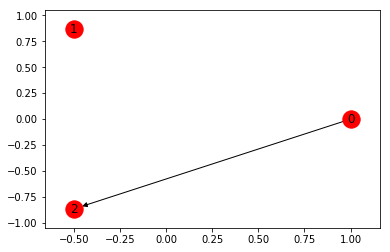

In [312]:
xx = prepare_network(get_macro(prepare_network(tpm), {0:4, 1:4, 2:2, 3:3}))
pos = nx.circular_layout(xx)
nx.draw_networkx_nodes(xx, pos)
nx.draw_networkx_edges(xx, pos)
nx.draw_networkx_labels(xx, pos)

{0: Text(1,2.38419e-08,'0'),
 1: Text(0.309017,0.951057,'1'),
 2: Text(-0.809017,0.587785,'2'),
 3: Text(-0.809017,-0.587785,'3'),
 4: Text(0.309017,-0.951056,'4')}

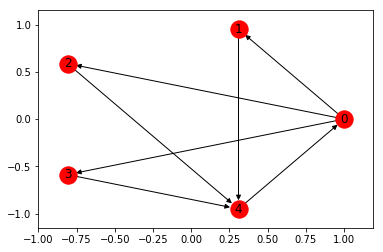

In [314]:
pos = nx.circular_layout(prepare_network(tpm))
nx.draw_networkx_nodes(prepare_network(tpm), pos)
nx.draw_networkx_edges(prepare_network(tpm), pos)
nx.draw_networkx_labels(prepare_network(tpm), pos)

In [267]:
prepare_network(G)

2
[0, 1]
[1]
3
0
[1, 2]
[2]
1
[0, 2]
[2]


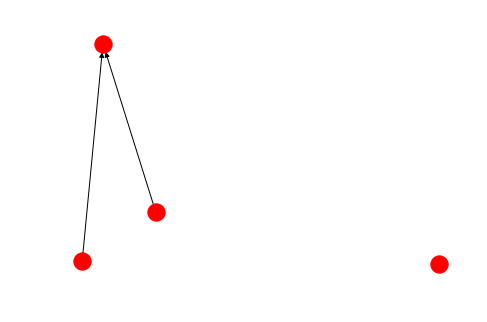

In [266]:
tpm = np.array([[1.0,0,0,0],
                [1.0,0,0,0],
                [1.0,0,0,0],
                [0,0,0,1.0]])
Gm = causal_emergence(tpm)
nx.draw(Gm)

In [236]:
nodes_in_macro_i = [k for k,v in possible_mapping.items() if v==node_i_macro]

for new_micro_in_macro_i in nodes_in_macro_i:
    neighbors_Mi = set(list(G.neighbors(new_micro_in_macro_i)))
    for node_Mj in neighbors_Mi:
        neighbors_Mj = set(list(G.neighbors(node_Mj)))
        neighbors_Mi = neighbors_j.union(neighbors_Mi)



In [243]:
new_friends_of_i = [i for i in list(neighbors_Mi) if i!=node_i]
list(set(new_friends_of_i) - set(macros_to_check))

[]

{0}

In [219]:
neighbors_i = set(list(G.neighbors(node_i)))
for node_j in neighbors_i:
    neighbors_j = set(list(G.neighbors(node_j)))
    neighbors_i = neighbors_j.union(neighbors_i)
macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
queue = macros_to_check.copy()

while len(queue) > 0:
    np.random.shuffle(queue)
    possible_macro = queue.pop()

    node_i_macro = macro_mapping[node_i]
    if node_i_macro == node_i:
        node_i_macro = max(list(macro_mapping.values()))+1

    possible_mapping = macro_mapping.copy()
    possible_mapping[node_i]         = node_i_macro
    possible_mapping[possible_macro] = node_i_macro

    MACRO = get_macro(G, possible_mapping, p0)
    macro_ei = get_ei(MACRO,p0)
    Gm = prepare_network(MACRO,p0=p0)


In [227]:
neighbors_Mi = set(list(Gm.neighbors(node_i_macro)))
for node_Mj in neighbors_Mi:
    neighbors_Mj = set(list(Gm.neighbors(node_Mj)))
    neighbors_Mi = neighbors_Mj.union(neighbors_Mi)
[i for i in list(neighbors_Mi)]

NetworkXError: The node 10 is not in the digraph.

In [226]:
node_i_macro

10

In [223]:
print(np.round(MACRO,2))
print(np.round(Wout,2))

[[0.   0.   0.5  0.   0.   0.   0.   0.   0.5 ]
 [0.   0.   0.33 0.33 0.   0.   0.   0.33 0.  ]
 [0.11 0.11 0.   0.11 0.11 0.11 0.11 0.11 0.22]
 [0.   0.14 0.14 0.   0.14 0.14 0.14 0.   0.29]
 [0.   0.   0.33 0.33 0.   0.   0.   0.   0.33]
 [0.   0.   0.25 0.25 0.   0.   0.25 0.   0.25]
 [0.   0.   0.33 0.33 0.   0.33 0.   0.   0.  ]
 [0.   0.33 0.33 0.   0.   0.   0.   0.   0.33]
 [0.1  0.   0.27 0.27 0.17 0.1  0.   0.1  0.  ]]
[[0.   0.   0.   0.33 0.33 0.   0.33 0.   0.   0.  ]
 [0.   0.   0.   0.5  0.   0.5  0.   0.   0.   0.  ]
 [0.   0.   0.   0.33 0.33 0.   0.   0.   0.   0.33]
 [0.11 0.11 0.11 0.   0.11 0.11 0.11 0.11 0.11 0.11]
 [0.14 0.   0.14 0.14 0.   0.14 0.14 0.14 0.14 0.  ]
 [0.   0.2  0.   0.2  0.2  0.   0.   0.2  0.   0.2 ]
 [0.33 0.   0.   0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.25 0.25 0.   0.   0.25 0.  ]
 [0.   0.   0.   0.33 0.33 0.   0.   0.33 0.   0.  ]
 [0.   0.   0.33 0.33 0.   0.33 0.   0.   0.   0.  ]]


In [215]:
    G = prepare_network(G, p0) # makes the network weighted, directed if it's not already
    current_ei = get_ei(G, p0)
    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    
    np.random.shuffle(micro_nodes_left)
    for node_i in range(1):
#     for node_i in micro_nodes_left:
        if node_i not in micros_that_have_been_macroed:
            print("Hi")
            # first assemble a list of node_js to span called macros_to_check
            neighbors_i = set(list(G.neighbors(node_i)))
            for node_j in neighbors_i:
                neighbors_j = set(list(G.neighbors(node_j)))
                neighbors_i = neighbors_j.union(neighbors_i)
            macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
            
#             while len(macros_to_check) > 0:
            np.random.shuffle(macros_to_check)
            possible_macro = macros_to_check.pop()

            node_i_macro = macro_mapping[node_i]
            if node_i_macro == node_i:
                node_i_macro = max(list(macro_mapping.values()))+1

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i] = node_i_macro
            possible_mapping[possible_macro] = node_i_macro
            
            MACRO = get_macro(G, possible_mapping, p0)
            if get_ei(MACRO,p0) - current_ei > thresh:
                
            

Hi


In [174]:
np.round(get_macro(G, macro_mapping),2)

array([[0.  , 0.  , 0.  , 0.33, 0.33, 0.  , 0.  , 0.33],
       [0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.  , 0.33, 0.33, 0.33, 0.  , 0.  ],
       [0.11, 0.11, 0.11, 0.  , 0.11, 0.11, 0.22, 0.22],
       [0.14, 0.  , 0.14, 0.14, 0.  , 0.  , 0.29, 0.29],
       [0.  , 0.  , 0.33, 0.33, 0.  , 0.  , 0.  , 0.33],
       [0.  , 0.  , 0.  , 0.29, 0.29, 0.  , 0.29, 0.13],
       [0.17, 0.1 , 0.  , 0.27, 0.27, 0.1 , 0.1 , 0.  ]])

In [121]:
macro_nodes = np.unique(list(macro_mapping.values()))
macro_out = too_big_macro[macro_nodes,:][:,macro_nodes]
macro_out = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
print(np.round(macro_out,2))

[[0.   0.   0.   0.33 0.33 0.   0.   0.33]
 [0.   0.   0.   0.5  0.   0.   0.   0.5 ]
 [0.   0.   0.   0.33 0.33 0.33 0.   0.  ]
 [0.11 0.11 0.11 0.   0.11 0.11 0.22 0.22]
 [0.14 0.   0.14 0.14 0.   0.   0.29 0.29]
 [0.   0.   0.33 0.33 0.   0.   0.   0.33]
 [0.   0.   0.   0.29 0.29 0.   0.29 0.13]
 [0.17 0.1  0.   0.27 0.27 0.1  0.1  0.  ]]


In [170]:
np.unique(list(macro_mapping.values()))

array([ 0,  1,  2,  3,  4,  9, 10, 11])

In [169]:
micro_network_size = G.number_of_nodes()
micro_Wout = get_Wout_full(G)
micro_nodes = np.unique(list(macro_mapping.keys()))
nodes_in_macro_network = np.unique(list(macro_mapping.values()))

macro_network_size = len(nodes_in_macro_network)
macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
n_macro = len(macro_nodes)

micro_to_macro_list = []
for macro_i in range(n_macro):
    micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
    micro_to_macro_list.append(micro_in_macro_i)

# get new rows
macro_row_list = []
for macro_i in micro_to_macro_list:
    macro_row_list.append(sum(Wout[macro_i,:]))

macro_rows = np.vstack(macro_row_list)

# get new cols
macro_col_list = []
for macro_i in micro_to_macro_list:
    macro_col_list.append(sum(Wout.T[macro_i,:]))

macro_cols = np.vstack(macro_col_list)    
macro_cols = macro_cols.T


# new lil square
# macro_bottom_right = np.zeros((n_macros,n_macros))

# macro_bottom_right[0, 0] = sum(macro_row1[macro1])
# macro_bottom_right[0, 1] = sum(macro_row1[macro2])
# macro_bottom_right[1, 0] = sum(macro_row2[macro1])
# macro_bottom_right[1, 1] = sum(macro_row2[macro2])
# print(np.round(macro_bottom_right, 2))

# get stubby diagonal square in the bottom right
macro_bottom_right = np.zeros((n_macro,n_macro))
for macro_i in range(n_macro):
    for macro_j in range(n_macro):
        macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])
print(macro_bottom_right)

[[0.58333333 0.25      ]
 [0.2        0.        ]]


In [166]:
macro_row_list[macro_i][micro_to_macro_list[macro_j]]

array([0.33333333, 0.25      ])

In [168]:
sum(macro_row1[macro1])
macro_row1[macro1]

array([0.33333333, 0.25      ])

In [164]:
sum(Wout[macro2,:])

array([0.33333333, 0.2       , 0.        , 0.53333333, 0.53333333,
       0.        , 0.        , 0.2       , 0.        , 0.2       ])

In [ ]:
# step 1 get rows:
# n_macros = # do unique and subtract form macro-mapiong
for macro_i in range(n_macros):
    # add new row
    # for keys with value macro_i sum the rows that coorespond to them


In [71]:
macro1 = [7,8]
macro2 = [5,6]
np.round(sum(Wout[macro1,:]),2)

array([0.  , 0.  , 0.  , 0.58, 0.58, 0.25, 0.  , 0.33, 0.25, 0.  ])

In [74]:
macro_row1 = sum(Wout[macro1,:])
macro_row2 = sum(Wout[macro2,:])
# macro_row1 = Wout[7,:] + Wout[8,:] 
# macro_row2 = Wout[5,:] + Wout[6,:]  <--- previously this, but is same

In [75]:
print(np.round(macro_row1, 2))
print(np.round(macro_row2, 2))

[0.   0.   0.   0.58 0.58 0.25 0.   0.33 0.25 0.  ]
[0.33 0.2  0.   0.53 0.53 0.   0.   0.2  0.   0.2 ]


In [78]:
# then get columns
macro_col1 = sum(Wout.T[macro1,:])
macro_col2 = sum(Wout.T[macro2,:])

In [79]:
print(np.round(macro_col1, 2))
print(np.round(macro_col2, 2))

[0.   0.   0.   0.22 0.29 0.2  0.   0.25 0.33 0.  ]
[0.33 0.5  0.   0.22 0.29 0.   0.   0.25 0.   0.33]


In [98]:
macro_row_list = [macro_row1,macro_row2]
macro_row = np.vstack(macro_row_list)

macro_col_list = [macro_col1,macro_col2]
macro_col = np.vstack(macro_col_list)
macro_col = macro_col.T

In [99]:
print("rows",np.round(macro_row,2))
print("cols",np.round(macro_col,2))

rows [[0.   0.   0.   0.58 0.58 0.25 0.   0.33 0.25 0.  ]
 [0.33 0.2  0.   0.53 0.53 0.   0.   0.2  0.   0.2 ]]
cols [[0.   0.33]
 [0.   0.5 ]
 [0.   0.  ]
 [0.22 0.22]
 [0.29 0.29]
 [0.2  0.  ]
 [0.   0.  ]
 [0.25 0.25]
 [0.33 0.  ]
 [0.   0.33]]


In [100]:
# new lil square
macro_bottom_right = np.zeros((n_macros,n_macros))

macro_bottom_right[0, 0] = sum(macro_row1[macro1])
macro_bottom_right[0, 1] = sum(macro_row1[macro2])
macro_bottom_right[1, 0] = sum(macro_row2[macro1])
macro_bottom_right[1, 1] = sum(macro_row2[macro2])
print(np.round(macro_bottom_right, 2))

[[0.58 0.25]
 [0.2  0.  ]]


In [86]:
# now put all together

In [101]:
too_big_macro = np.block([[Wout, macro_col], [macro_row, macro_bottom_right]])
print(np.round(too_big_macro,2))

[[0.   0.   0.   0.33 0.33 0.   0.33 0.   0.   0.   0.   0.33]
 [0.   0.   0.   0.5  0.   0.5  0.   0.   0.   0.   0.   0.5 ]
 [0.   0.   0.   0.33 0.33 0.   0.   0.   0.   0.33 0.   0.  ]
 [0.11 0.11 0.11 0.   0.11 0.11 0.11 0.11 0.11 0.11 0.22 0.22]
 [0.14 0.   0.14 0.14 0.   0.14 0.14 0.14 0.14 0.   0.29 0.29]
 [0.   0.2  0.   0.2  0.2  0.   0.   0.2  0.   0.2  0.2  0.  ]
 [0.33 0.   0.   0.33 0.33 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.25 0.25 0.   0.   0.25 0.   0.25 0.25]
 [0.   0.   0.   0.33 0.33 0.   0.   0.33 0.   0.   0.33 0.  ]
 [0.   0.   0.33 0.33 0.   0.33 0.   0.   0.   0.   0.   0.33]
 [0.   0.   0.   0.58 0.58 0.25 0.   0.33 0.25 0.   0.58 0.25]
 [0.33 0.2  0.   0.53 0.53 0.   0.   0.2  0.   0.2  0.2  0.  ]]


In [1037]:
W_out = np.zeros((macro_size,macro_size))
for row in range(len(macro_dict.keys())):
    join_yes = macro_dict[macro_dict_keys[row]]
    join_not = np.array(list(set(list(current_mapping.keys())) - set(join_yes)))
    if len(join_yes)>1:
        macro_nodes_id = join_yes[0]
        macro_other_nodes = list(set(list(range(macro_size))) - set([macro_nodes_id]))
        other_nodes_id = list(set(current_mapping.keys()) - set(join_yes))
    for i in range(len(W_out_macro[row])):
        if i in join_yes:
            W_out[row][macro_nodes_id] += W_out_macro[row][i]
    W_out[row][macro_other_nodes] += W_out_macro[row][other_nodes_id]
#       W_out[row][other_nodes_id] = W_out_macro[row][join_not]

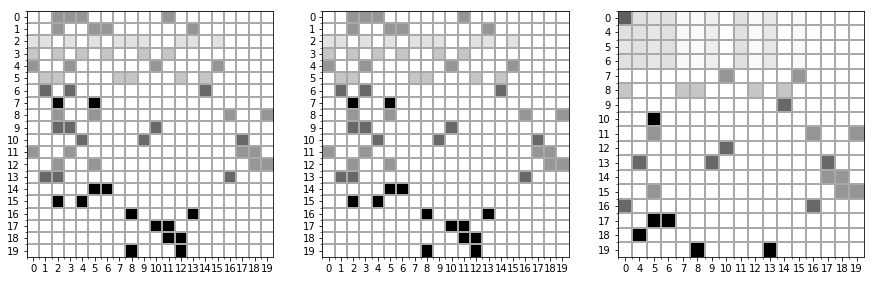

In [1038]:
fig, (ax1, ax2, ax3) = plt.subplots(1,sp,figsize=(h*sp,h))
ax1.imshow(W_out_micro, cmap='Greys')
ax1.set_xticks(np.arange(0, W_out_micro.shape[0], 1));
ax1.set_yticks(np.arange(0, W_out_micro.shape[0], 1));
ax1.set_xticklabels(np.arange(0, W_out_micro.shape[0], 1));
ax1.set_yticklabels(np.arange(0, W_out_micro.shape[0], 1));
ax1.set_xticks(np.arange(-.5, W_out_micro.shape[0]-0.5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, W_out_micro.shape[0]-0.5, 1), minor=True);
ax1.grid(which='minor', color='darkgrey', linestyle='-', linewidth=2)

ax2.imshow(test, cmap='Greys')
ax2.set_xticks(np.arange(0, test.shape[0], 1));
ax2.set_yticks(np.arange(0, test.shape[0], 1));
ax2.set_xticklabels(ordering);
ax2.set_yticklabels(ordering);
ax2.set_xticks(np.arange(-.5, test.shape[0]-0.5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, test.shape[0]-0.5, 1), minor=True);
ax2.grid(which='minor', color='darkgrey', linestyle='-', linewidth=2)

ax3.imshow(W_out, cmap='Greys')
ax3.set_xticks(np.arange(0, W_out.shape[0], 1));
ax3.set_yticks(np.arange(0, W_out.shape[0], 1));
ax3.set_xticklabels(list(macro_dict.keys()));
ax3.set_yticklabels(list(macro_dict.keys()));
ax3.set_xticks(np.arange(-.5, W_out.shape[0]-0.5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, W_out.shape[0]-0.5, 1), minor=True);
ax3.grid(which='minor', color='darkgrey', linestyle='-', linewidth=2)

plt.show()

In [1226]:
p0 = 0.001
N = 20
m = 1
ns = [3,4,5,6,7,8]
ce = {}
for nm in ns:
    print(nm)
    n_macros = []
    causal_e = []
    for numb in range(10000):
#         G = nx.barabasi_albert_graph(N,m)
        G = nx.erdos_renyi_graph(N, 0.05)
        G = check_network(G)
        A = nx.to_numpy_array(G)
        W_out_micro = get_Wout_full(G, p0)

        macro_yes = list(set([N-i for i in range(1,nm)]))
        macro_not = list(set(list(current_mapping.keys()))-set(macro_yes))
        macro_slice_yes = W_out_micro[macro_yes]
        macro_slice_not = W_out_micro[macro_not]

        macro_slice = macro_slice_yes.sum(axis=0)
        macro_slice_ijs = macro_slice[macro_yes].sum(axis=0)
        macro_slice_out = list(macro_slice[macro_not])
        macro_slice_out.append(macro_slice_ijs)
        macro_slice_row = np.array(macro_slice_out)

        micro_slice_ijs = macro_slice_not.T[macro_yes].T
        micro_slice_out = list(macro_slice_not.T[macro_not])
        micro_slice_out.append(micro_slice_ijs.sum(axis=1))
        micro_slice_col = np.array(micro_slice_out).T
        
        if macro_slice_row.sum(axis=0) > 0:
            W_out = np.vstack((micro_slice_col, macro_slice_row/macro_slice_row.sum(axis=0)))
        else:
            break
            
        sp=2
        h=6
        ei_Macro = get_ei(W_out, p0)
        ei_Micro = get_ei(W_out_micro, p0)
        if ei_Macro > ei_Micro:
            n_macros.append(len(macro_yes))
            causal_e.append(ei_Macro-ei_Micro)
            if np.random.rand() < 0.01:
                print(ei_Macro-ei_Micro)
                fig, (ax1,ax2) = plt.subplots(1,sp,figsize=(h*sp,h))

                ax1.imshow(W_out_micro*2, cmap='Greys')
                ax1.set_xticks(np.arange(0, W_out_micro.shape[0], 1));
                ax1.set_yticks(np.arange(0, W_out_micro.shape[0], 1));
                ax1.set_xticklabels(np.arange(0, W_out_micro.shape[0], 1));
                ax1.set_yticklabels(np.arange(0, W_out_micro.shape[0], 1));
                ax1.set_xticks(np.arange(-.5, W_out_micro.shape[0]-0.5, 1), minor=True);
                ax1.set_yticks(np.arange(-.5, W_out_micro.shape[0]-0.5, 1), minor=True);
                ax1.grid(which='minor', color='darkgrey', linestyle='-', linewidth=2)
                ax1.set_title(get_ei(W_out_micro, p0))

                ax2.imshow(W_out*2, cmap='Greys')
                ax2.set_xticks(np.arange(0, W_out.shape[0], 1));
                ax2.set_yticks(np.arange(0, W_out.shape[0], 1));
                ax2.set_xticklabels(np.arange(0, W_out.shape[0], 1));
                ax2.set_yticklabels(np.arange(0, W_out.shape[0], 1));
                ax2.set_xticks(np.arange(-.5, W_out.shape[0]-0.5, 1), minor=True);
                ax2.set_yticks(np.arange(-.5, W_out.shape[0]-0.5, 1), minor=True);
                ax2.grid(which='minor', color='darkgrey', linestyle='-', linewidth=2)
                ax2.set_title(get_ei(W_out, p0))

                plt.show()
    ce[nm] = [n_macros, causal_e]

3
4
5
6
7
8


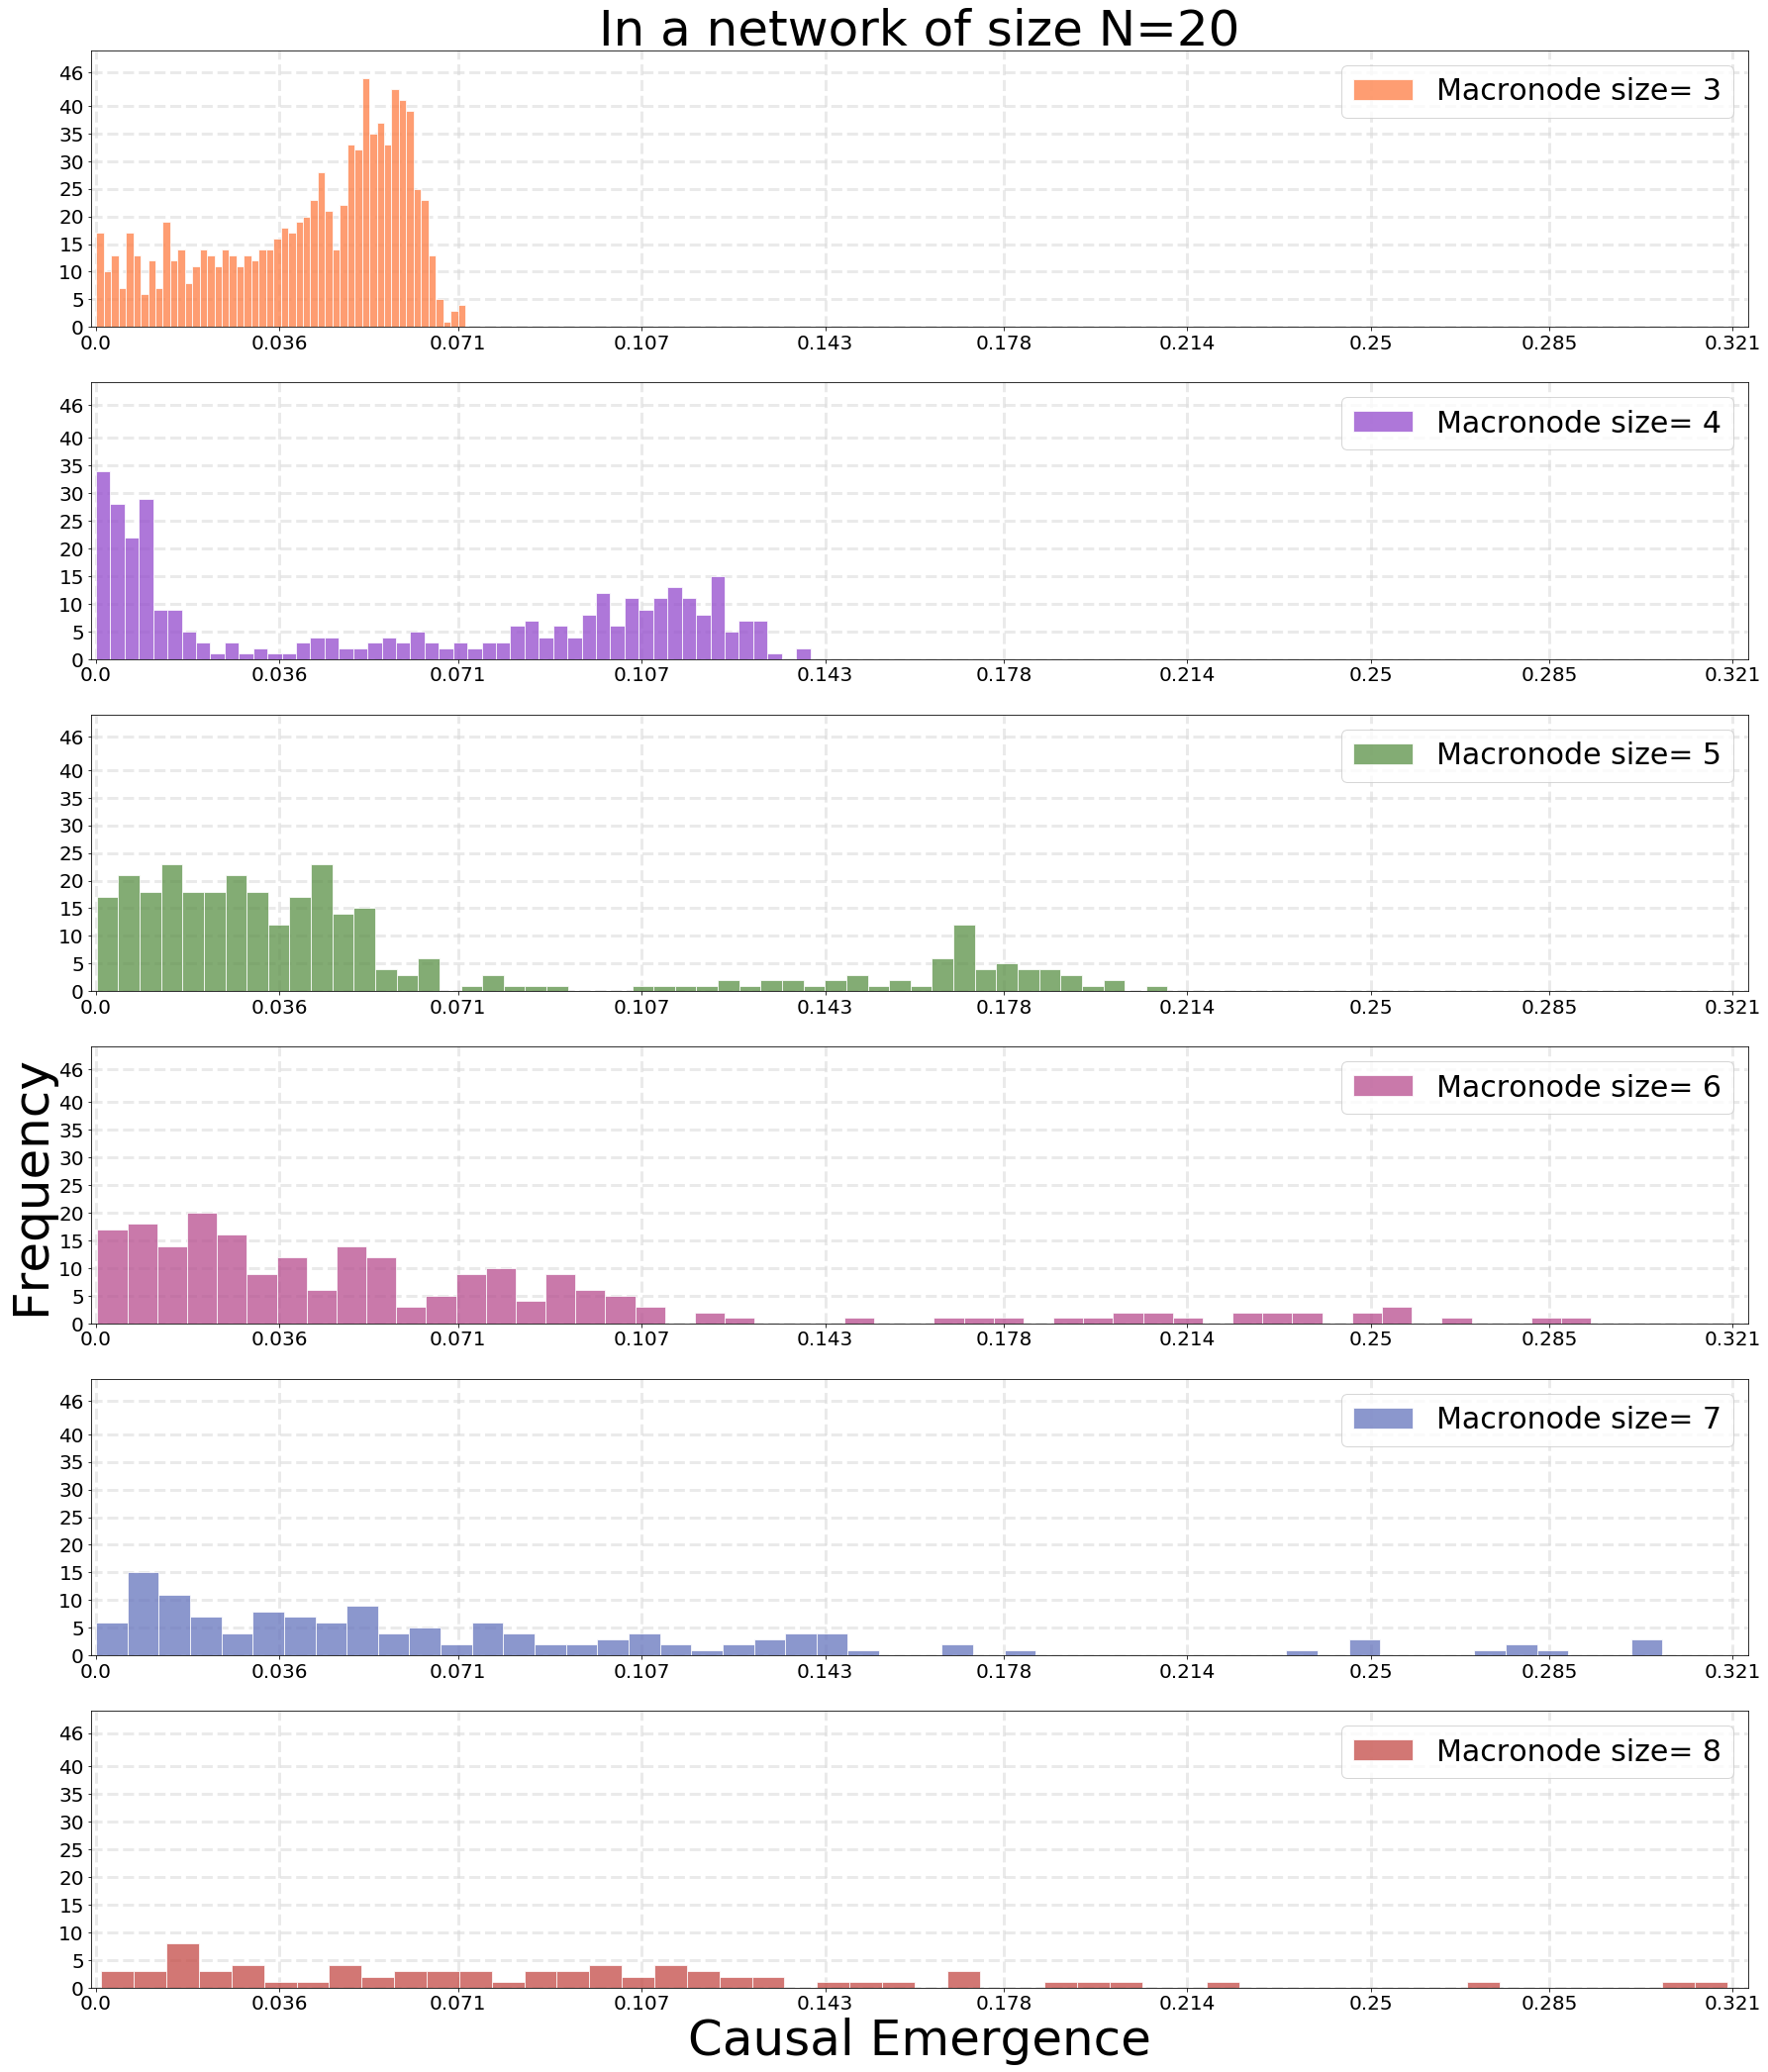

In [1224]:
cols = ["#fe7d43","#934acd","#5a9046","#b74c8e","#6574bd","#c44a45"]
fig, ax = plt.subplots(len(ns), 1, figsize=(5*len(ns),6*len(ns)))
for nm in range(len(ns)):
    ax[nm].hist(ce[ns[nm]][1], bins=50, color=cols[nm], edgecolor='w', linewidth=1.0,
                alpha=0.75, label="Macronode size= "+str(ns[nm]))
    ax[nm].legend(fontsize=30)
    ax[nm].set_yticks(np.linspace(0,46,10,dtype=int))
    ax[nm].set_xticks(np.round(np.linspace(0,0.321,10),3))
    ax[nm].set_yticklabels(np.linspace(0,46,10,dtype=int), fontsize=20)
    ax[nm].set_xticklabels(np.round(np.linspace(0,0.321,10),3), fontsize=20)
    ax[nm].set_xlim(-0.001,.324)
    ax[nm].set_ylim(0,50)
    ax[nm].set_axisbelow(True)
    ax[nm].grid(alpha=0.6, color='gainsboro', linestyle='--', linewidth=3.0)
ax[3].set_ylabel("Frequency", size=50)
ax[0].set_title("In a network of size N=20", size=50)
ax[nm].set_xlabel("Causal Emergence", size=50)

plt.savefig("figs/pngs/N20_causalEmergence.png", dpi=425, bbox_inches='tight')
plt.savefig("figs/pdfs/N20_causalEmergence.pdf", dpi=425, bbox_inches='tight')
plt.show()

In [693]:
from scipy.stats import gaussian_kde

## 5.2.0 Bipartite Structure

In [4]:
def make_bipartite(N_left_side, N_right_side, N_lattice=2, conn="across"):

    left_side = range(N_left_side)
    right_side = range(N_left_side, (N_left_side+N_right_side))
    G = nx.Graph()
    G.add_nodes_from(left_side)
    G.add_nodes_from(right_side)
    attrs = {}
    color = {}
    for i in left_side:
        attrs[i] = 'left'
        color[i] = 'white'
    for i in right_side:
        attrs[i] = 'right'
        color[i] = 'dodgerblue'
    nx.set_node_attributes(G, attrs, 'side')
    nx.set_node_attributes(G, color, 'color')
    
    if conn=='across' or conn=='both':
        for i in range(len(left_side)):
            G.add_edge(left_side[i], right_side[i])
    
    if conn=='degen':
        for i in range(len(left_side)):
            G.add_edge(left_side[i], right_side[0])

    if N_lattice==0:
        return G
    
    lattice_nodes = list(range(N_lattice))
    backwards = len(lattice_nodes)
    for i in lattice_nodes:
        for j in lattice_nodes:
            if i!=j:
                G.add_edge(left_side[i], right_side[j])
    
    labels = dict(zip(list(G.nodes()), list(np.array(G.nodes(), dtype=str))))
    nx.set_node_attributes(G, labels, 'label')
    
    return G

In [5]:
def get_pos(G, N_left_side=3, N_right_side=3):
    
    left_side = range(N_left_side)
    right_side = range(N_left_side, (N_left_side+N_right_side))

    pos = {}
    y_range = [0, max([N_left_side, N_right_side])]
    x_range = [-0.5, 0.5]
    left_x  = np.linspace(x_range[0], x_range[0], num=N_left_side)
    right_x = np.linspace(x_range[1], x_range[1], num=N_right_side)
    left_y  = np.linspace(y_range[0], y_range[1], num=N_left_side)
    right_y = np.linspace(y_range[0], y_range[1], num=N_right_side)
    
    for i in left_side:
        pos[i] = np.array([left_x[i], left_y[i]])
        
    for i, r in enumerate(right_side):
        pos[r] = np.array([right_x[i], right_y[i]])
    
    return pos

## End of Chapter 06.
_______________

### References:
- __[Anderson, P. W. (1972). More is different. Science,177(4047), 393–396. doi: 10.1126/science.177.4047.393](http://robotics.cs.tamu.edu/dshell/cs689/papers/anderson72more_is_different.pdf)__
- __[Bunge, M. (1963). A General Black Box Theory. Philosophy of Science, 30(4), 346–358. doi: 10.1086/287954](https://www.journals.uchicago.edu/doi/10.1086/287954)__
- __[Campbell, D. T. (1974). ‘Downward Causation’ in Hierarchically Organised Biological Systems. In *Studies in the philosophy of biology.* (pp. 179–186). doi: 10.1007/978-1-349-01892-5-11](https://link.springer.com/chapter/10.1007%2F978-1-349-01892-5_11)__
- __[Crutchfield, J. P. (1994). The Calculi of Emergence. Physica D, 75, 11–54. doi: 10.1016/0167-2789(94)90273-9](https://www.sciencedirect.com/science/article/pii/0167278994902739)__
- __[Fodor, J. A. (1974). Special Sciences (Or: The Disunity of Science as a Working Hypothesis). Synthese,28(2), 97–115. doi: 10.1007/BF00485230](https://www.jstor.org/stable/20114958)__
- __[Hoel, E. P. (2017). When the Map Is Better Than the Territory. Entropy, 19(5), 188. doi: 10.3390/e19050188](http://www.mdpi.com/1099-4300/19/5/188)__
- __[Hoel, E. P., Albantakis, L., & Tononi, G. (2013). Quantifying causal emergence shows that macro can beat micro. Proceedings of the National Academy of Sciences, 110(49), 19790–5. doi: 10.1073/pnas.1314922110](http://www.pnas.org/content/110/49/19790)__
- __[Kim, J. (2000). Mind in a physical world: An essay on the mind-body problem and mental causation. MITPress.](https://mitpress.mit.edu/books/mind-physical-world)__
- __[Shannon, C. E. (1948). A mathematical theory of communication. The Bell System Technical Journal, 27(July 1928), 379–423. doi: 10.1145/584091.584093](http://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)__
- __[Sperry, R. W. (1969). A modified concept of consciousness. Psychological Review, 76(6), 532–536. doi: 10.1037/h0028156](http://www.informationphilosopher.com/solutions/scientists/sperry/Sperry_Modified_Consciousness.pdf)__
- __[Wolpert, D. H., Grochow, J. A., Libby, E., & DeDeo, S. (2014). Optimal high-level descriptions of dynamical systems. arXiv, 1–33.](https://arxiv.org/abs/1409.7403)__